# DSCI 552 Lecture 1 - Generalized Linear Models: Binary Logistic Regression

## High-Level Goals of this Course

- Describe the risk and value of making parametric assumptions in regression.
- Fit model functions that represent probabilistic quantities besides the mean.
- Identify situations where Ordinary Least-Squares (OLS) regression is sub-optimal, and apply alternative regression methods that better address the situation.

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Recall the basics of OLS regression.
- Identify cases where OLS regression is not suitable.
- Distinguish what makes a regression model "*linear*".
- Explore the concept of the link function.
- Explain the concept of generalized linear models (GLMs).
- Differentiate a GLM from an OLS regression model.
- Build up the first fundamental GLM: Binary Logistic regression. 

## Loading `R` Packages and Scripts

In [1]:
options(repr.matrix.max.rows = 6)
source("scripts/support_functions.R")
library(tidyverse)
library(mlbench)
library(AER)
library(cowplot)
library(broom)
library(performance)
library(qqplotr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──


✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Loading required package: car



Loading required package: carData




Attaching package: ‘car’




The following object is masked from ‘package:dplyr’:

    recode




The following object is masked from ‘package:purrr’:

    some




Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival




Attaching package: ‘qqplotr’




The following objects are masked from ‘package:ggplot2’:

    stat_qq_line, StatQqLine




## 1. Basics of Ordinary Least-Squares Regression

In **DSCI 561**, you learned comprehensive material about OLS regression. Why are we using the term **ordinary**? This term refers to a linear model with a **response** (also known as **endogenous variable**) of **continuous nature**. From **DSCI 551**, recall that a continuous variable can take on an infinite number of real values in a given range. This response is subject to **regressors** (also known as **exogenous variables**, **explanatory variables**, **features**, or **predictors**). Note that the regressors can be of a continuous or discrete nature. When the regressors are **discrete** and **factor-type** (i.e., with different categories), they could be: 

- **Nominal.** In this factor-type, we have categories associated that do not follow any specific order. For example, a clinical trial with a factor of three treatments: *placebo*, *treatment A*, and *treatment B*.
- **Ordinal.** The categories, in this case, follow a specific order. A typical example is the Likert scale of survey items: *strongly disagree*, *disagree*, *neutral*, *agree*, and *strongly agree*.

```{important} 
The ordinary linear case is a practical starting point for explaining regression models.
```

Conceptually, a linear regression model can be expressed as:

$$
\mbox{Response} = \mbox{Systematic Component} + \mbox{Random Component}.
$$ (eq-conceptual_model)

- The **systematic component** represents the mean of the response **which is conditioned on the regressor values**. 
- The **random component** measures the extent to which the observed value of the response might deviate from its mean and is viewed as **random noise**.

For the $i$th observation in our **sample** or **training data** ($i = 1, \dots, n$), the conceptual model {eq}`eq-conceptual_model` is mathematically represented as:

$$
\underbrace{Y_i}_\text{Response}  = \underbrace{\beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_p g_p(X_{i,p})}_\text{Systematic Component} + \underbrace{\varepsilon_i.}_\text{Random Component}
$$

Note the following:

- The response $Y_i$ is equal to the sum of $p + 2$ terms.
- The systematic component is the sum of:
    - An **unknown intercept** $\beta_0$ and
    - $p$ **regressor functions** $g_j(X_{i,j})$ multiplied by their respective **unknown regression coefficient** $\beta_j$ ($j = 1, \dots, p$).
- $\varepsilon_i$ is the **random noise**.

The equation above for $Y_i$ is more detailed as follows:

- The response $Y_i$ depends on the **linear combination** of the functions $g_j(\cdot)$ of $p$ regressors $X_{i, j}$ of different types (continuous and discrete). 
- Each function $g_j(X_{i,j})$ has an associated regression coefficient. These parameters $\beta_{1}, \dots, \beta_{p}$ represent how much the response is expected to increase or decrease when the function $g_j(X_{i,j})$ changes by one unit of the $j$th regressor. An additional parameter $\beta_0$ represents the mean of the response when all the $p$ functions $g_j(X_{i,j})$ are zero. All these elements represent the systematic component of the model.

- The term $\varepsilon_i$ is an unobserved random variable and represents the random component. These variables are **usually** assumed to be **normally distributed** with **mean of zero** and a **common variance** $\sigma^2$ (i.e., **homoscedasticity**). Moreover, all $\varepsilon_i$s are assumed to be **independent**. This can be represented as follows:

```{math}
\begin{gather*}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather*}
```

- Hence, **each $Y_i$ is also assumed to be independent and normally distributed**:

$$
Y_i \mid X_{i, j} \sim \mathcal{N} \big( \beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_p g_p(X_{i,p}), \sigma^2 \big).
$$

### 1.1. Can We Apply Linear Regression Here?

Having briefly discussed the components of the OLS model, let us explore three 2-$d$ examples made with simulated data.

**In-class Activity**

In what example(s) can we apply linear regression?

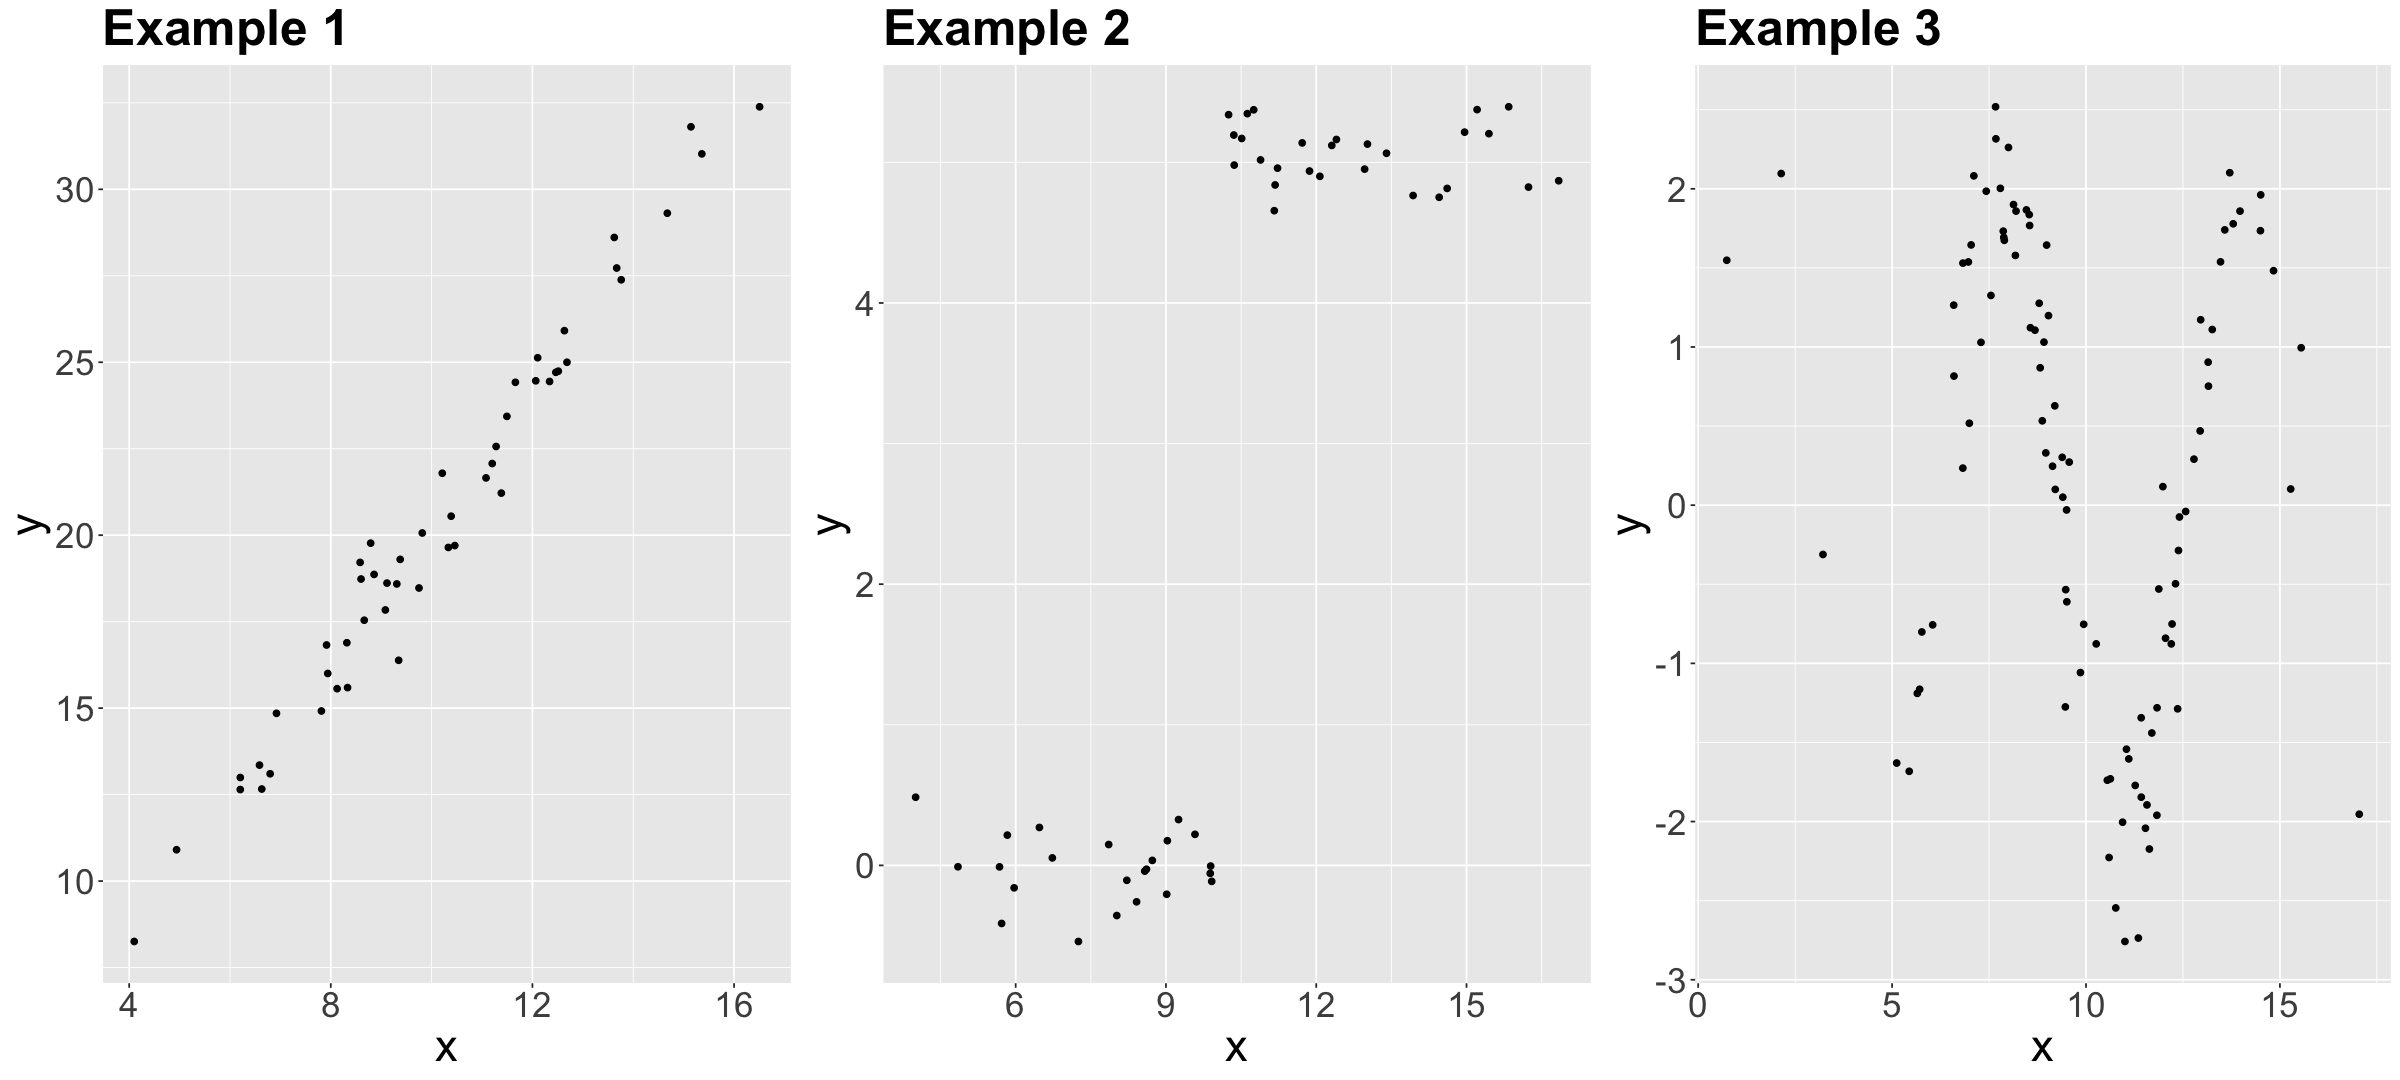

In [2]:
options(repr.plot.height = 9, repr.plot.width = 20)
plot_grid(example_1(), example_2(), example_3(), nrow = 1)

**Answer:**

It turns out that the data used for the three plots above come from a linear model. Note that they are **linear on their parameters (i.e., coefficients)** but not on their corresponding regressor $X$. So we have to make three crucial remarks in these examples:

- **Example 1** is the classical case of simple OLS regression.
- Conversely, **Example 2** does not show a clear linear relationship between both variables unless our linear approach makes two subsets of points. In that case, we could apply two local linear regression models (to be covered in this course in a further lecture).
- Finally, **Example 3** comes from a sinusoidal curve with an additional random noise (below, we provide more details on this case).

### 1.2. What makes a regression model "*linear*"?

Let us retake the **Example 3** from our previous activity.

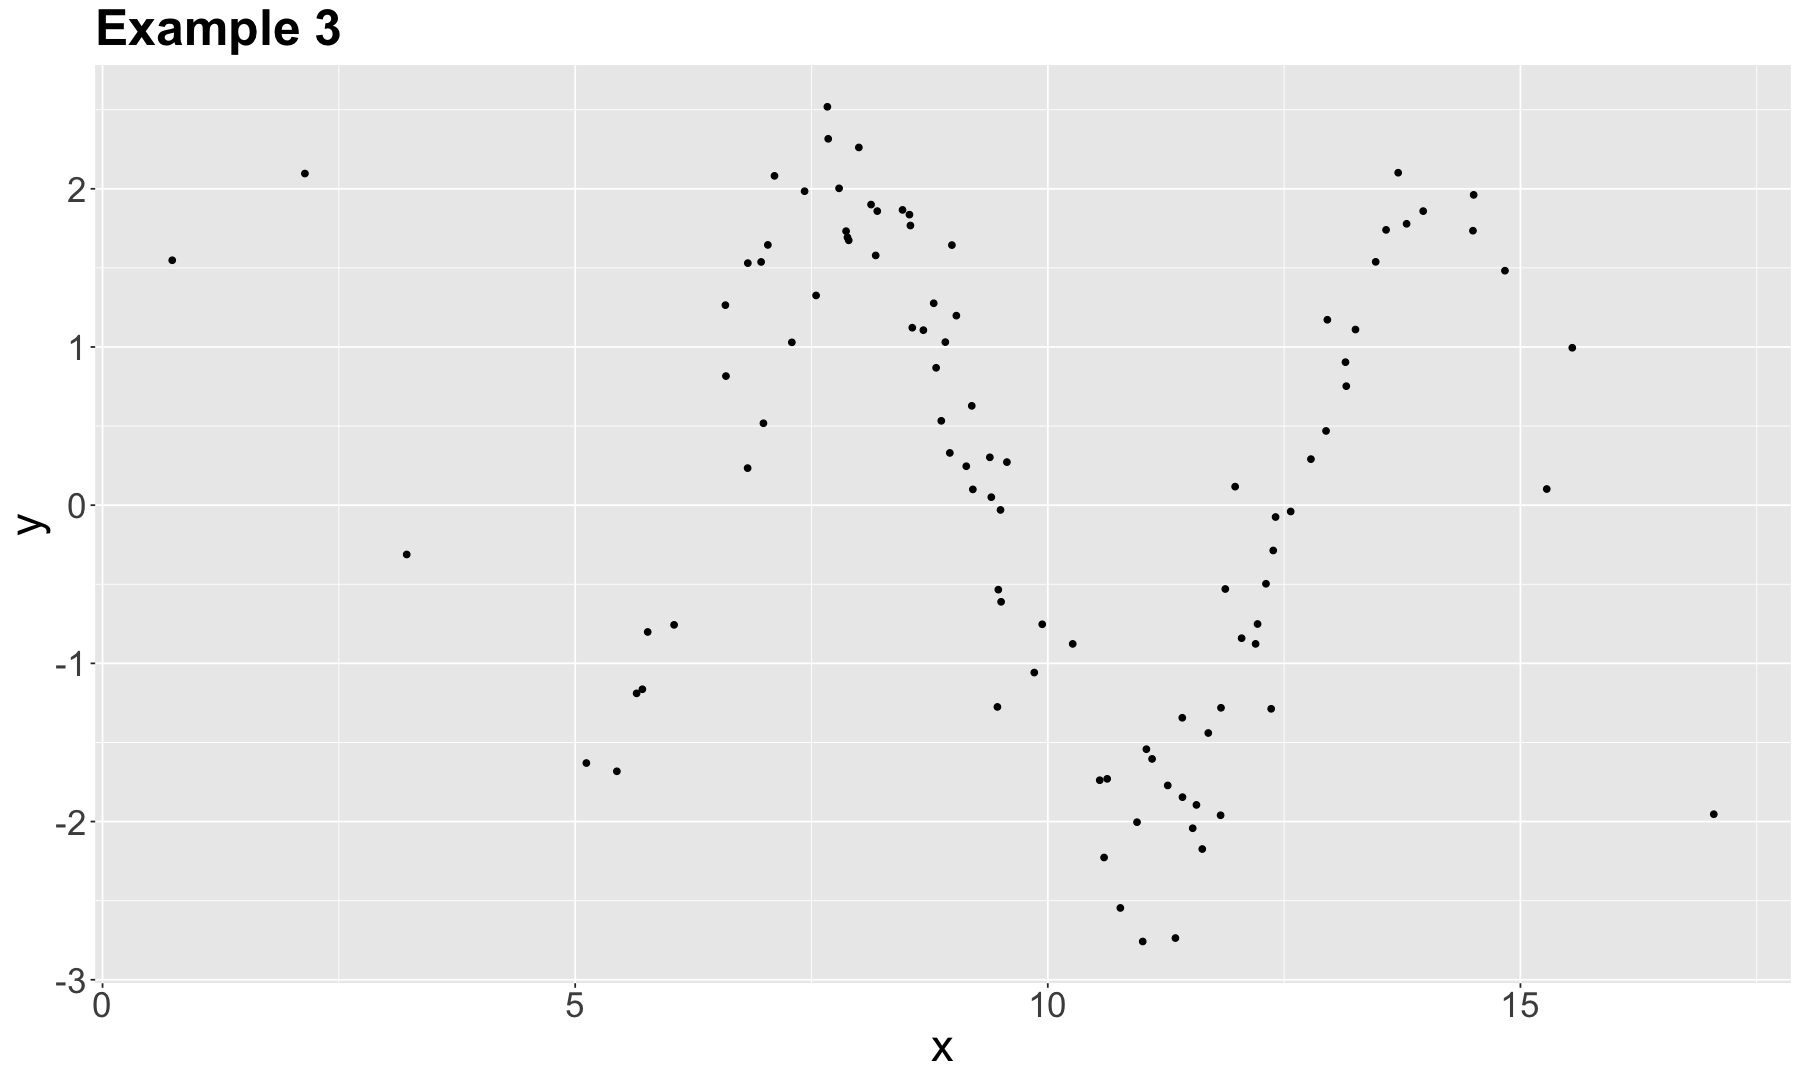

In [3]:
options(repr.plot.height = 9, repr.plot.width = 15)
example_3()

It turns out that each synthetic data point was generated from a sinusoidal curve plus some normally distributed random noise:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g(X_i) + \varepsilon_i \\
&= \beta_0 + \beta_1 \sin(X_i) + \varepsilon_i.
\end{align*}
```

As we can see, this example can be modelled as an OLS model **if we transform each $x_i$ in the training set as $\sin(x_i)$**.

Now, let use generalize all these previouse ideas. When a linear regression model has more than one regressor, then we call it **multiple linear regression model**.

OLS implicate the identity function $g_j(X_{i, j}) = X_{i, j}$, leading to:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g_1(X_{i, 1}) + \ldots + \beta_p g_p(X_{i,p}) + \varepsilon_i \\
&= \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_p X_{i,p} + \varepsilon_i.
\end{align*}
```

```{important}
The use of the above identity function makes the model "linear" on the parameters, not the regressors.
```

Finally, suppose we have a training dataset of $n$ observations, i.e. for $i = 1, \dots, n$. Then all the $X_{i, j}$ become observed values $x_{i, j}$ (note the lowercase), leading to the following conditional expected value of the OLS model above as:

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_p x_{i,p} \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

We can see that the regression coefficients' interpretation is targeted to explain each regressor's numerical **association** (**or effect if we are conducting an experiment!**) on the mean of the response, **if we fulfill the assumptions on the random component** $\varepsilon_i$.

### 1.3. Categorical Regressors

If the $j$th explanatory variable of interest is continuous, its observed value is expressed as a single $x_{i,j}$ for the $i$th observation. 

Suppose a explanatory variable of interest is nominal. In that case, we will need to use a dummy variable to identify the category to which each observation belongs. For instance, if a discussed categorical explanatory variable of interest has $m$ categories or levels, we could define $m-1$ dummy variables as shown in the coding scheme in {numref}`dummy-var`. Note that **Level 1** is taken as the baseline (reference) level: if the $i$th observation belongs to **Level 1** then all the dummy variables $x_{i,1}, \cdots, x_{i,(m -1)}$ take on the value $0$. The choice of baseline has an impact on the interpretation of the regression coefficients. The baseline is related to the role of the intercept $\beta_0$.

```{list-table} Dummy variables in a nominal regressor with $m$ levels.
:header-rows: 1
:name: dummy-var

* - **Level**
  - $x_{i, 1}$
  - $x_{i, 2}$
  - $\cdots$
  - $x_{i, (m - 1)}$
* - $1$
  - $0$
  - $0$
  - $\cdots$
  - $0$
* - $2$
  - $1$
  - $0$
  - $\cdots$
  - $0$
* - $\vdots$
  - $\vdots$
  - $\vdots$
  - $\ddots$
  - $\vdots$
* - $m$
  - $0$
  - $0$
  - $\cdots$
  - $1$
```

### 1.4. Estimation

The next matter to address is how to estimate our model parameters since these are unknown. In order to fit a linear regression model for a given training dataset of $n$ observations, we have to estimate the $p + 2$ parameters $\beta_0, \beta_1, \dots, \beta_p, \sigma^2$ by **minimizing the sum of squared residuals** (i.e., **least-squares estimation**) or **maximizing the likelihood function of the sample**. 

The **likelihood function** is the **joint probability density function** of the observed data as a function of the unknown parameters $\beta_0, \beta_1, \dots, \beta_p, \sigma^2$ we are willing to estimate. A particular distribution is assumed for the individual observations. Maximum likelihood estimation aims to find the values of those parameters for which the observed data is more likely. The likelihood function for the multiple linear regression model is described as follows:

- We assume a random sample of $n$ elements. Thus, the Normal $Y_i$s are independent, which allows us to obtain the sample's joint probability density function. 
- The joint function is obtained by multiplying the $n$ Normal probability density functions altogether. This joint probability density function is mathematically equal to the likelihood function of the observed data.
- The maximum likelihood method takes the first partial derivatives of the **log-likelihood function** with respect to $\beta_0, \beta_1, \dots, \beta_p, \sigma^2$. Then, we set these derivatives equal to zero and isolate the corresponding terms. This procedure yields the maximum likelihood estimates.
- The case of simple linear regression (as in $\beta_0$, $\beta_1$, and $\sigma^2$) can be handled in scalar notation. However, in the presence of a considerable number of coefficients, it is more efficient to work with the model in matrix notation. Then, matrix calculus comes into play.

```{important}
Now, we might wonder: **how is maximum likelihood estimation (MLE) related to OLS?** This is the point were the assumptions on the error component $\varepsilon_i$ have a key role in MLE. If we make the corresponding mathematical derivations, **it turns out that maximizing the log-likelihood function is equivalent to minimizing the sum of squared residuals**.
```

### 1.5. Inference

The estimated model can be used for two purposes: **inference** and **prediction**. In terms of inference, we use the fitted model to identify the relationship between the response and regressors. We will need the $j$th estimated regression coefficient $\hat{\beta}_j$ and its corresponding variability which is reflected in the **standard error** of the estimate, $\mbox{se}(\hat{\beta}_j)$. To determine the statistical significance of $\hat{\beta}_j$, we use the **test statistic**

$$t_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0.
\end{gather*}
```

A statistic like $t_j$ is referred to as a $t$-value. It has a $t$-distribution **under the null hypothesis** $H_0$ with $n - p - 1$ degrees of freedom.

We can obtain the corresponding $p$-values for each $\beta_j$ associated to the $t$-values under the null hypothesis $H_0$. **The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$ in our sample**. Hence, small $p$-values (less than the significance level $\alpha$) indicate that the data provides evidence in favour of association between the response variable and the $j$th regressor. Similarly, given a specified $(1-\alpha) \times 100\%$ level of confidence, we can construct **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm t_{\alpha/2, n - p - 1}\mbox{se}(\hat{\beta}_j),
$$

where $t_{\alpha/2, n - p- 1}$ is the upper $\alpha/2$ quantile of the $t$-distribution with $n - p - 1$ degrees of freedom.

### 1.6. Violations of Assumptions

Recall the multiple linear regression model is defined as

$$
Y_i = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_p X_{i,p} + \varepsilon_i,
$$

where $\varepsilon_i$ (random component) is subject to these assumptions:

```{math}
:label: OLS-assumptions
\begin{gather}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather}
```

Now, what would happen if the assumptions in {eq}`OLS-assumptions` are violated? The **diagnostic plots** below belong to simulated data whose OLS models violate the **normality assumption**.

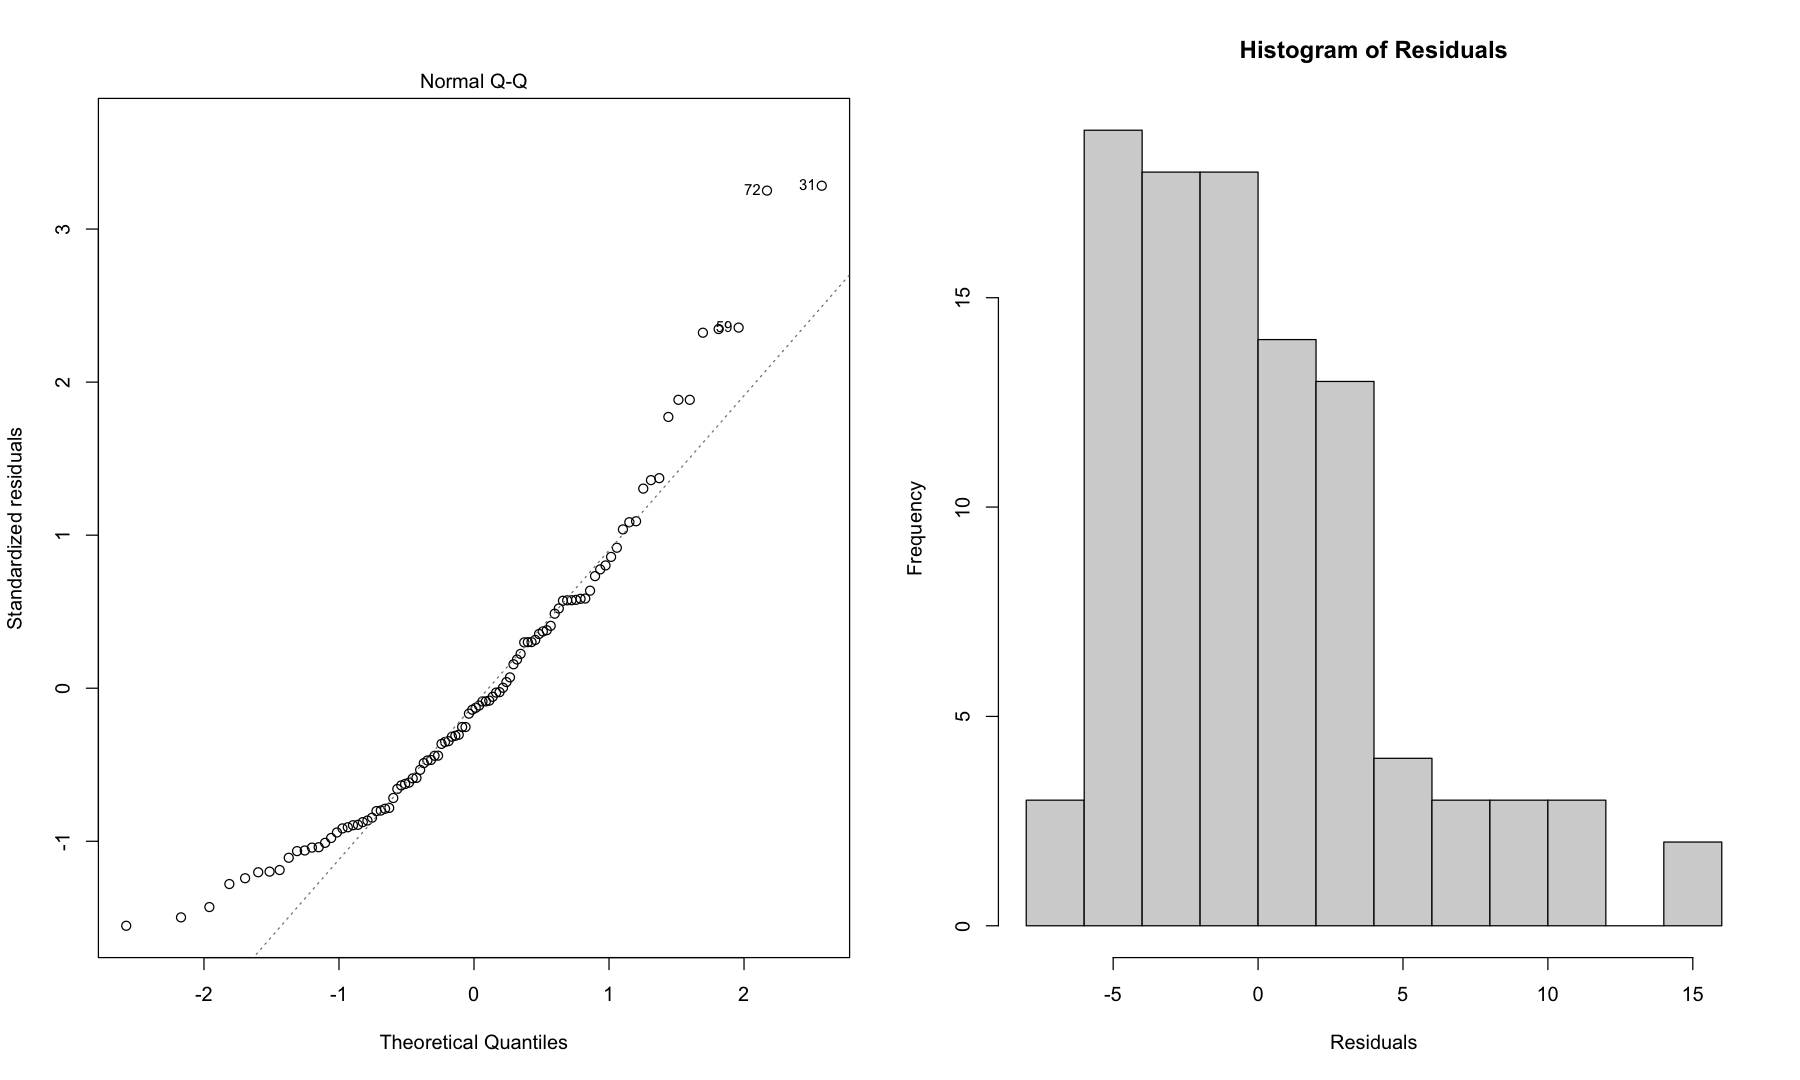

In [4]:
example_non_normality()

Recall the **$Q$-$Q$ plot** and **histogram of residuals** are graphical tools that help us to assess the normality assumption as follows:

- In the case of the $Q$-$Q$ plot, the ideal result is having all the data points lying on the 45° degree dotted line. This result means that all **standardized residuals** coming from the fitted model are equal to the theoretical quantiles coming from the **Standard Normal distribution**, i.e., $\mathcal{N}(0, 1)$. However, for the case above, a considerable proportion of these data points is not lying on the 45° degree dotted line, suggesting **non-normality**.
- For the histogram of residuals, we would expect a **bell-shaped** form as in the Normal distribution. Nonetheless, the plot above suggests a right-skewed distribution (also known as positive skewed).

A distributional misspecification (i.e., assuming normality when it is not the case) has severe implications for the associated tests ($t$ and $F$-tests). The distributions of the test statistics under $H_0$ rely on the normality assumption!

On the other hand, **homoscedasticity** can be assessed via the diagnostic plot of **residuals vs. fitted values**. The ideal result would show a uniform cloud of data points. However, the plot below (coming from an OLS model fitted with simulated data) shows a clear pattern composed of two funnel shapes. This pattern indicates non-constant variance, i.e., **heteroscedasticity**.

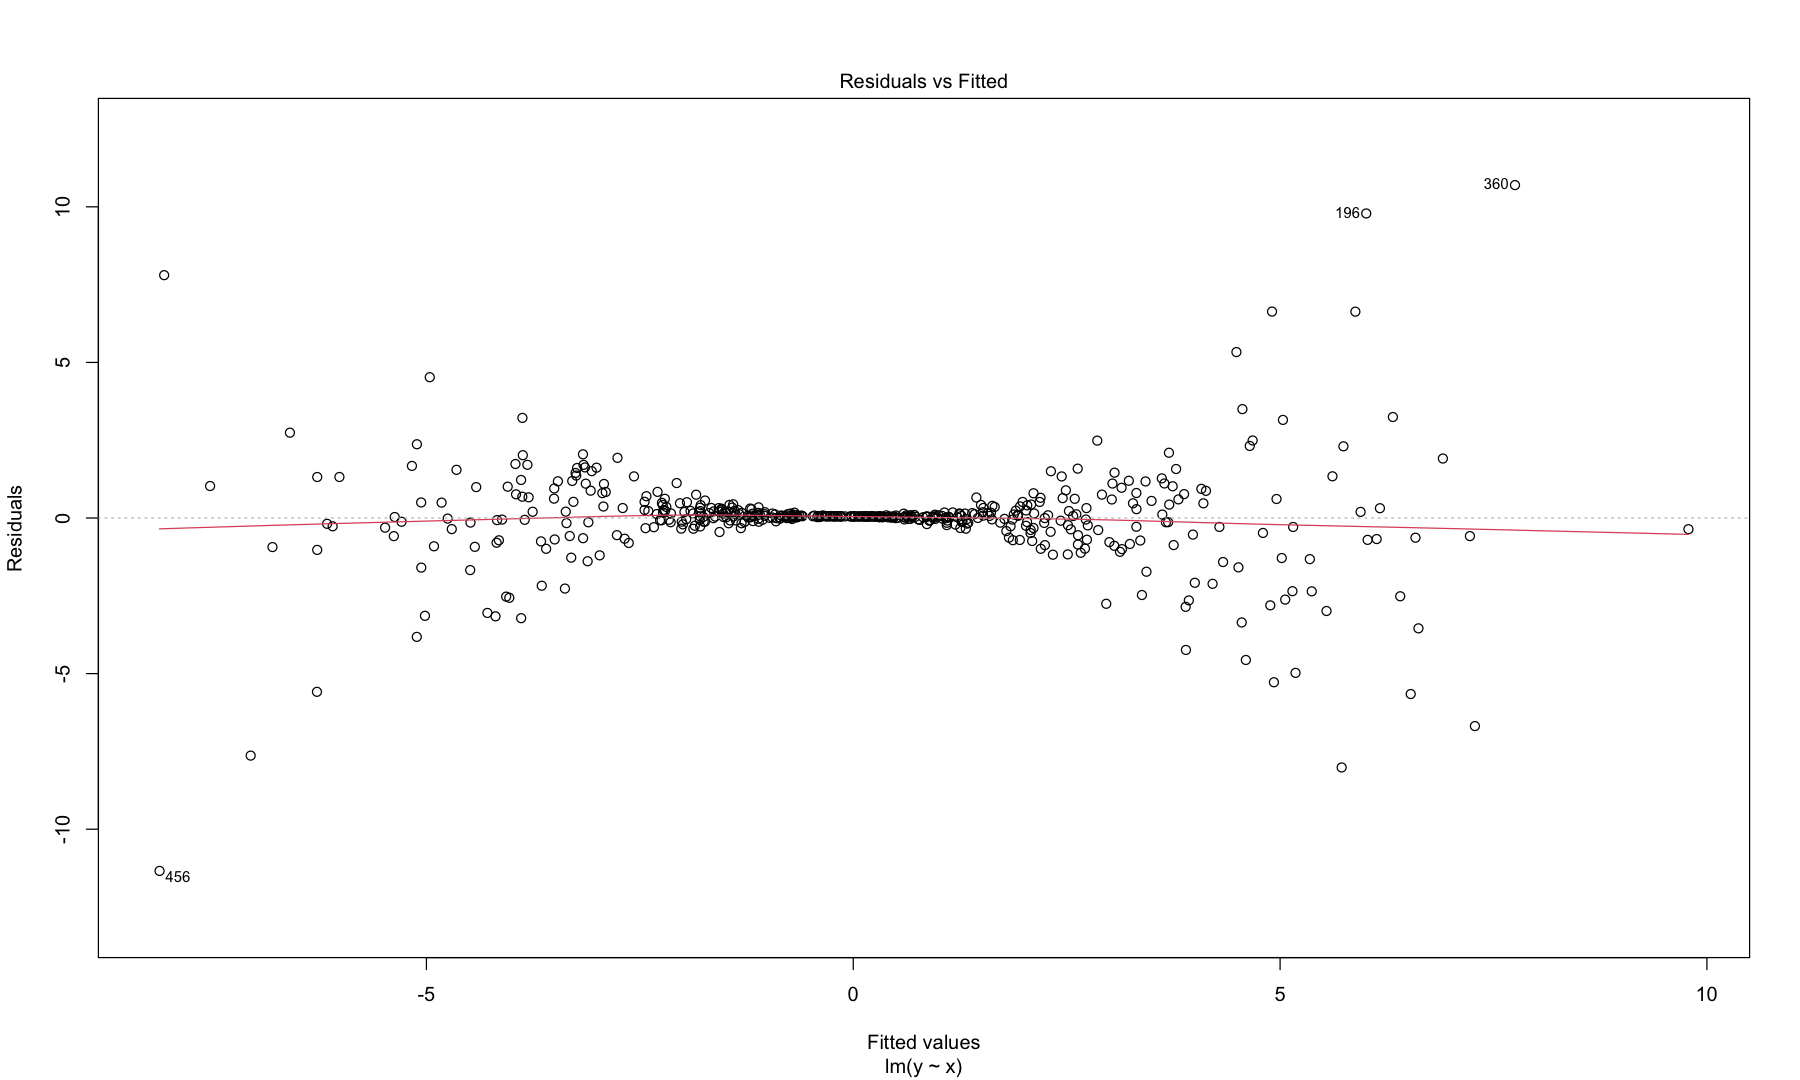

In [5]:
example_heteroscedasticity()

Below, you can find further information on the implications of assumption violations.

#### 1.6.1. Distributional Misspecification

Fulfilling the model's assumptions on the errors $\varepsilon_i$ considerably impacts the statistical tests of the multiple linear regression model. The distributions of the test statistics, such as the $t$ or the $F$-values, heavily rely on the normality of the $\varepsilon_i$s. Suppose we do not fulfil the normality on the random component. In that case, these test statistics will not be reliable unless **our sample size $n$ is large enough** (i.e., **an asymptotical approximation**). Then, we are at stake of drawing misleading statistical conclusions on significance. Recall that hypothesis testing assumes a particular distribution under the null hypothesis $H_0$, which is related to these random components' normality for this model in the $t$ and $F$-tests.

#### 1.6.2. Random Components with Non-Zero Mean

Suppose we misspecified the mean in our multiple linear regression model for our random components, i.e., $\mathbb{E}(\varepsilon_i) = c \neq 0$. This misspecification would be a mild violation. It will be absorbed by the intercept $\beta_0$ leading to 

$$\beta_0^* = \beta_0 + c$$ 

and reflected in the model estimate for the intercept. Note that this $c$ is constant over all the $n$ $\varepsilon_i$s. Nonetheless, suppose there is a further regressor $X_{i, p+1}$ not taken into account. In that case, we are at stake in obtaining **biased model estimates** and misleading statistical conclusions on significance. Therefore, we define this further regressor $X_{i, p+1}$ as a **lurking variable**.

#### 1.6.3. Heterocedasticity

We already defined homoscedasticity as the fact that all $\varepsilon_i$s have $\sigma^2$ as a common variance. However, this assumption commonly gets violated in multiple linear regression and is called heteroscedasticity: the variance of the $\varepsilon_i$s is not constant. **A common approach to solve this problem is a response transformation, usually logarithmical if it is positive.**

#### 1.6.4. Correlated Random Components

When we have correlated random components, we are also at the stake of assuming misspecified distributions on our statistical tests. Alternative modelling could deal with this matter (e.g., **mixed-effects models** to be covered in this course). Again, this correlation leads to misspecified distributions in the $t$ and $F$-tests since the test statistics heavily rely on independence under the null hypothesis $H_0$. The independence between random components could be confirmed via a **Durbin-Watson test**.

## 2. When Ordinary Linear Regression Does Not Suffice

The OLS model from **DSCI 561** allows the response to take on any real number. Nonetheless, this is not entirely true in many real-life datasets. 

We usually encounter cases where the response's range is restricted. Therefore, this linear regression model is not suitable. Thus, **what can we do about it?**

```{attention}
The statistical literature offers an interesting set of models that could deal with different types of responses in real life. This set of models will be introduced in this course while providing illustrative examples we might encounter in data analysis.
```

We could list some examples where the response cannot be used in the OLS model:

- **Non-negative values.** The median value of owner-occupied homes in USD 1000's (`medv`) in the dataset `BostonHousing` [(Harrison and Rubinfeld, 1978)](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwnV07T8MwELYQDLDwKCDeyghDaOy0TixVSICourBVYrRc50wBNVRtQeLfc-fEpYAQiMF5nB9JbOf8Obn7zFgqzpP4i04wgANV7iQgPC-gZTOligRsAiYRhfWLOSya6pz_8EOfyyZhgjiRSp5m-RmteClj0sBpm5NBV-_2aq6H88QvLTfPEBznfijk88BE9pkWQd-nMWplAmOwC-NPd4PdBS-eYHjyxS_wG7njH59pk63XkDS6rPrQFluCssFWg8fytMF2bz684TBhrQ6m22zWGZnJ00UPCiLY7TT9WTR8JmP6-6iKHBNr0TTEmbKIEHLWcQWMUBDiED7XcrwNUwZxJTIPk1qww_rdm_51L66XcYh5KomtVGZGtJwcEO-NQplVvCDqQwlKcGvBtp2yhjxghZFu4KRSTqZcDFomFZDusuXyuYQ9FqlMICISMLA0L3WpqrhpXAvz2MLl-ywOTajHFVmHDlZsVMea6lhnufZ1rAWmD-38x_RZ6Ay6BigV8NDYor_kvPR9Z34ZAHgEqmT9qlPTxvCGgeOcHncPdIhhjCHnWKrQw9no4N9XP2Rr3DMp05ejI7Y8m7zAsaeZOPGvjN9evwO2Ww2r).

```{note}
The data frame `BostonHousing` contains information of 506 tracts of Boston from the 1970 US Census. Suppose we want to make inference or predict the response `medv`, subject to the other 13 regressors in the dataset. In this case, the nature of the response does not allow it to take on negative values.
```

In [6]:
data(BostonHousing)
str(BostonHousing)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : num  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ b      : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


- **Binary outcomes (Success or Failure).** Whether a tumour is `benign` or `malignant` (`Class`) in the dataset `BreastCancer` [(Wolberg and Mangasarian, 1990)](https://libkey.io/libraries/498/articles/35797998/full-text-file?utm_source=api_542).

```{note}
The data frame `BreastCancer` contains information of 699 biopsy results. Suppose we want to make inference or predict the response `Class`, subject to the other 9 regressors in the dataset (except `Id`). The response is discrete of binary type.
```

In [7]:
data(BreastCancer)
str(BreastCancer)

'data.frame':	699 obs. of  11 variables:
 $ Id             : chr  "1000025" "1002945" "1015425" "1016277" ...
 $ Cl.thickness   : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 5 5 3 6 4 8 1 2 2 4 ...
 $ Cell.size      : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 4 1 8 1 10 1 1 1 2 ...
 $ Cell.shape     : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 4 1 8 1 10 1 2 1 1 ...
 $ Marg.adhesion  : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 1 5 1 1 3 8 1 1 1 1 ...
 $ Epith.c.size   : Ord.factor w/ 10 levels "1"<"2"<"3"<"4"<..: 2 7 2 3 2 7 2 2 2 2 ...
 $ Bare.nuclei    : Factor w/ 10 levels "1","2","3","4",..: 1 10 2 4 1 10 10 1 1 1 ...
 $ Bl.cromatin    : Factor w/ 10 levels "1","2","3","4",..: 3 3 3 3 3 9 3 3 1 2 ...
 $ Normal.nucleoli: Factor w/ 10 levels "1","2","3","4",..: 1 2 1 7 1 7 1 1 1 1 ...
 $ Mitoses        : Factor w/ 9 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 5 1 ...
 $ Class          : Factor w/ 2 levels "benign","malignant": 1 1 1 1 1 2 1 1 1 1 ...


- **Count data.** The number of physician office visits (`visits`) in the dataset `NMES1988` [(Deb and Trivedi, 1997)](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwnV1tS8MwEA5uftAvvk6cL6N_oK5L0pfJUEr34gQZ4j75JaZLCsOtzqng_os_1kuTDjsVwU-lF9oL5Mg9x909hxDBZ469cick3G0GggcJ9YXHSUIDb6RyXn6DgsPmcqVUx89bY1SVZVYmmCX1AS_FE1nHOHCxiy9nz7aaHqWyrGaURgmVwEI1Te7yPlYM7BpLEtvHLi54IF2E-AWZUuNautvoId9FXlOy0vJX5G38x3Z30JaBnVao7WQXrcl0D23kXckv--ijNeXzx4u2nPJUtOrZi6VlAGstk88pLqjepaIkXlgAKK2OGv09WZi1c7MYWt2xQrjFT27G7yqJURSGhuncSCto2O0MoyvbTG6wAT4Ejg0xVSAVdTyn2PeJkBC4yKRBhUdHHuFurPphMSAzAXCPOwnAGgHOWkoVrwEoPUDl9CmVh6rySgDkGIlmTByaSCfmIwExYRx7SSBjX1bRID9MNtP8HEwzMWPG7vpRX6XYmwxgnMtUTY0DD8wIIw3CWNhvs-uwQ6kDEodFA4ZZr4oq2REuf2fOr4puMxv5puYPLT8qMZKjX3Qdo01Nk6sKK09Q-XX-Jk8zXogaWm9H94NeLbPxT5yWAM4). This response takes on count values ($0, 1, 2, 3, \dots$).

```{note}
The `NMES1988` data frame contains cross-sectional data from the US National Medical Expenditure Survey (NMES) between 1987 and 1988. It is a sample of 4,406 individuals of ages 66 and above covered by Medicare with 19 different variables. Suppose we are interested in making inference or predicting the number of `visits` subject to regressors `age`, `gender`, and `income`.
```

In [8]:
data(NMES1988)
str(NMES1988)

'data.frame':	4406 obs. of  19 variables:
 $ visits   : int  5 1 13 16 3 17 9 3 1 0 ...
 $ nvisits  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ovisits  : int  0 2 0 5 0 0 0 0 0 0 ...
 $ novisits : int  0 0 0 0 0 0 0 0 0 0 ...
 $ emergency: int  0 2 3 1 0 0 0 0 0 0 ...
 $ hospital : int  1 0 3 1 0 0 0 0 0 0 ...
 $ health   : Factor w/ 3 levels "poor","average",..: 2 2 1 1 2 1 2 2 2 2 ...
  ..- attr(*, "contrasts")= num [1:3, 1:2] 1 0 0 0 0 1
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:3] "poor" "average" "excellent"
  .. .. ..$ : chr [1:2] "poor" "excellent"
 $ chronic  : int  2 2 4 2 2 5 0 0 0 0 ...
 $ adl      : Factor w/ 2 levels "normal","limited": 1 1 2 2 2 2 1 1 1 1 ...
 $ region   : Factor w/ 4 levels "northeast","midwest",..: 4 4 4 4 4 4 2 2 2 2 ...
  ..- attr(*, "contrasts")= num [1:4, 1:3] 1 0 0 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:4] "northeast" "midwest" "west" "other"
  .. .. ..$ : chr [1:3] "northeast" "midwest" "west"
 $ age

## 3. Paving the Way to Generalized Linear Models

When we are using a set of regressors (or **predictors**) to explain (or **predict**) our response, we have to establish a mathematical relationship between them. This is called a **functional form** (i.e., **model function**). For instance, in the case of the regressor $X$ and response $Y$, we could have:

- **Linear:** $Y = \beta_0 + \beta_1 X$.
- **Exponential:** $Y = e^{\beta_0 + \beta_1 X}$.
- **In general:** $Y = f(X)$.

### 3.1. Nature of the Model Function

Once we establish the model function between our variables, we have to specify the nature of it:

- **Deterministic.** For each one of the values of the regressor $X$, there is a single value of $Y$.
- **Stochastic.**  Each value of $X$ has a probability distribution associated to $Y$. 

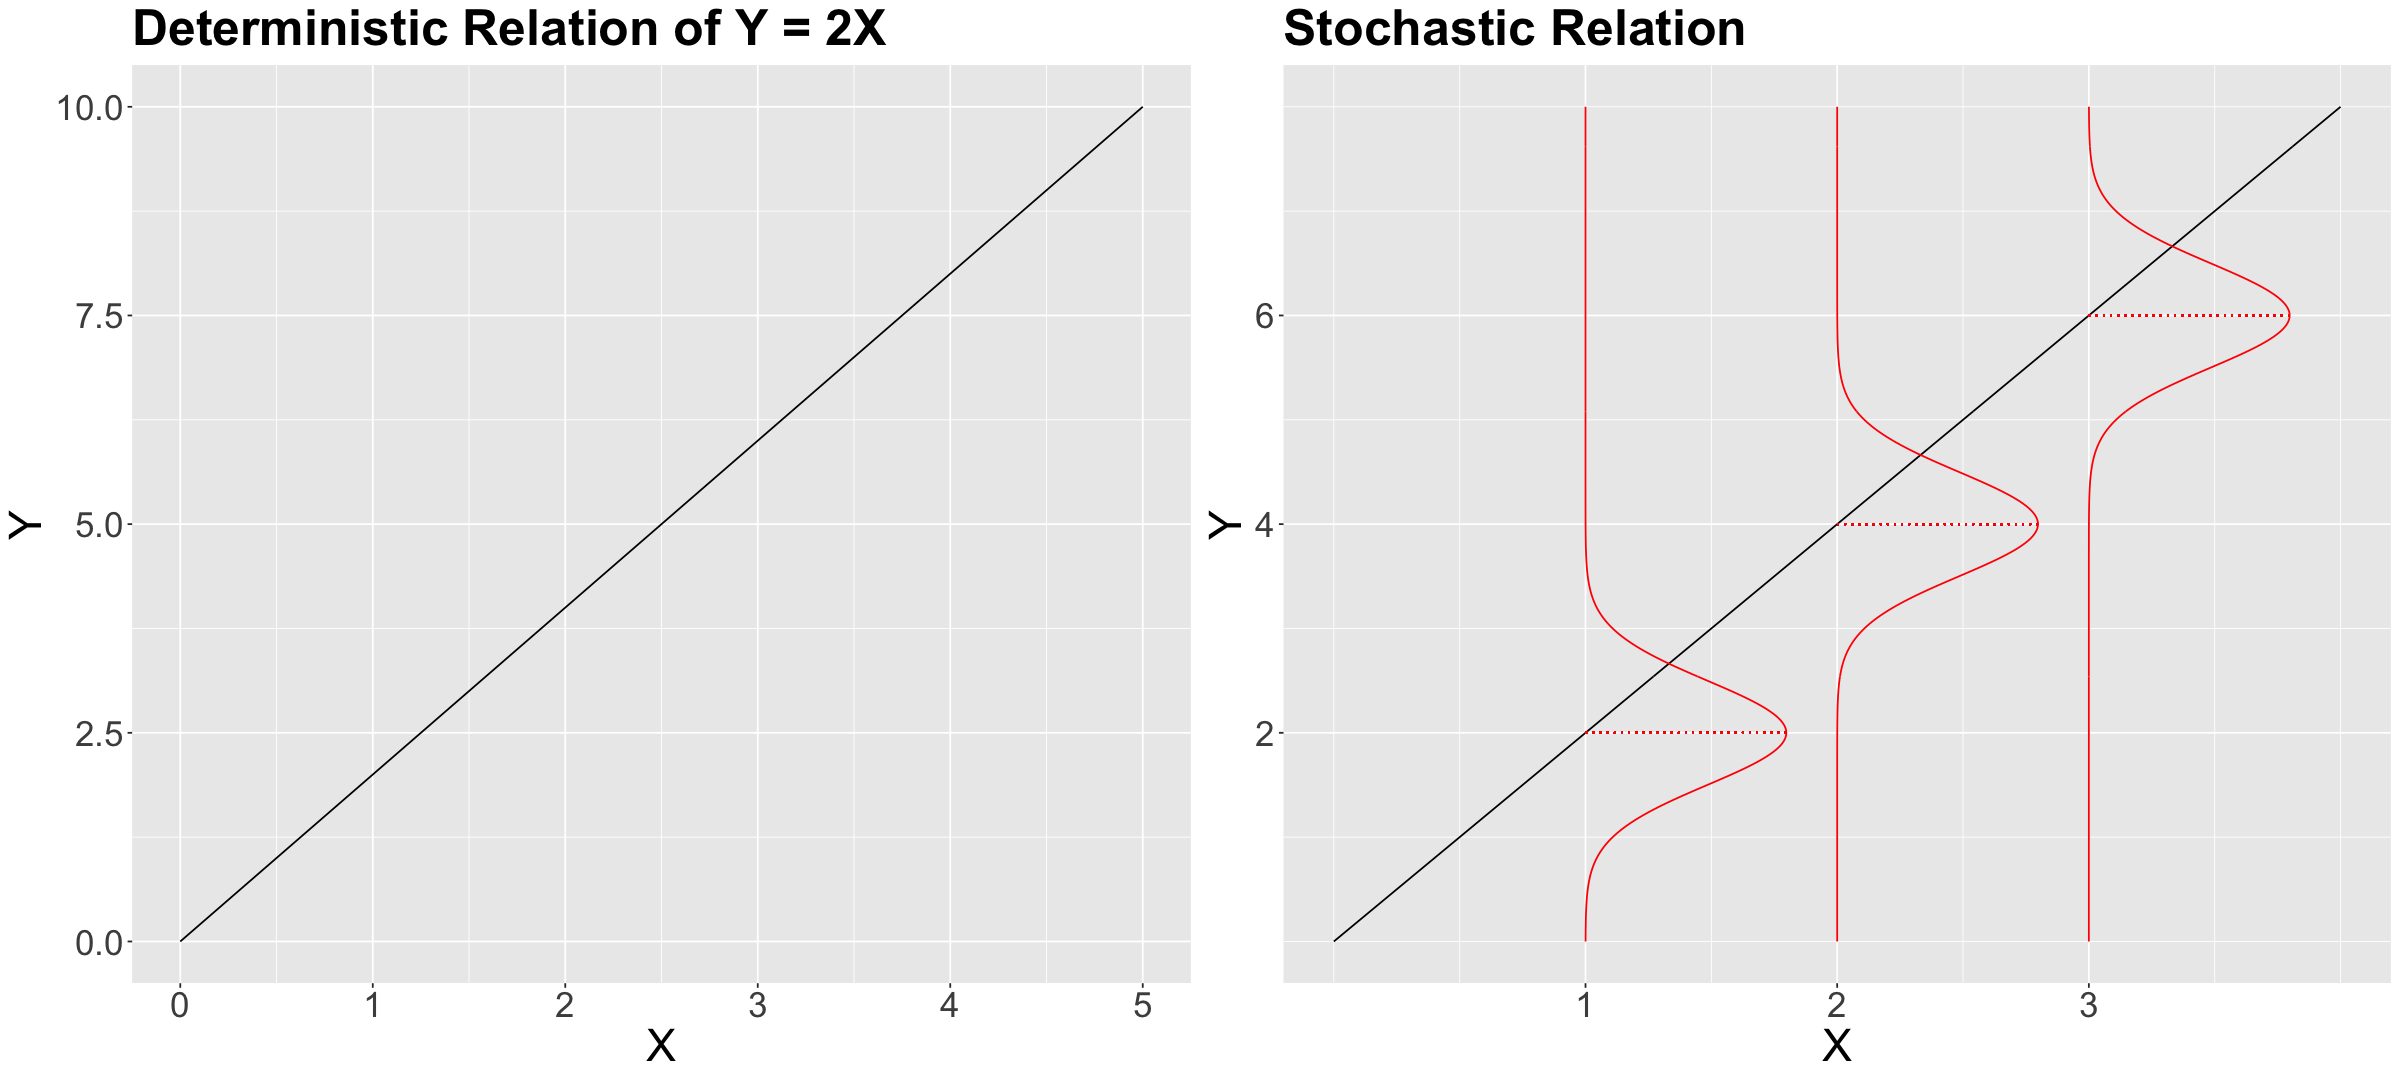

In [9]:
options(repr.plot.height = 9, repr.plot.width = 20)
plot_grid(example_deterministic_relation(), example_stochastic_relation(), nrow = 1)

### 3.2. The Regression Problem

The term **regression** can be extended beyond a linear relationship between the response and regressors. From the previous review on OLS multiple linear regression, the model can be used for two purposes:

- **Inference.** We want to determine whether there is a significant statistical association between the response and regressor (e.g., $t$-tests in ordinary multiple linear regression) and estimate the **effect size**. 
    - There is uncertainty associated with this estimation (confidence intervals).
- **Prediction.** Given new values for the regressors, we want to predict the corresponding value of the response subject to the effect estimates. 
    - There is uncertainty associated with this prediction (prediction intervals).

### 3.3. Black-box Models

A model such as in the case of multiple linear regression, specifies the functional form between the regressors and the response along with assumptions on the system or phenomenon we aim to model. This allows interpretability.

On the other hand, a **black-box model** is focused on **optimizing predictions** subject to a set of regressors with less attention on the internal model's process.

### 3.4. Interpretability in Linear Models

A crucial characteristic of linear models is their relative easiness to interpret the effects of the regressors on the response (via the model's coefficients). Moreover, their predictive ability is fair in general. An additional takeaway on this class of tools is their ability to go beyond the conditioned modelling of the response's means (e.g., medians or certain quantiles).

### 3.5. The Types of Parametric Assumptions

The concept of a **parametric model** varies depending on the field:

- In Computer Science, a parametric model assumes a functional relationship between the regressors and response (e.g., linear).
- In Statistics, a parametric model has distributional assumptions on its components.

### 3.6. An example where OLS regression totally goes wrong

We have to be careful when using linear models in specific complex datasets if we only appeal to their easiness of interpretability. When we do not capture the right functional form between the regressors and the response, the chances of having a misspecified model are high. For the sake of this example, we will build a simulated dataset similar to the previous **Example 3**. Assume that the true functional form in this 2-$d$ example is as follows:

```{math}
\begin{align*}
Y_i &= \beta_0 + \beta_1 g(X_i) + \varepsilon_i \\
&= \beta_0 + \beta_1 \sin(X_i) + \varepsilon_i \\
&= 5 + 10 \sin(X_i) + \varepsilon_i
\end{align*}
```

with 

```{math}
\begin{gather*}
\mathbb{E}(\varepsilon_i) = 0 \\
\text{Var}(\varepsilon_i) = \sigma^2 \\
\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
\varepsilon_i \perp \!\!\! \perp \varepsilon_k \; \; \; \; \text{for} \; i \neq k  \; \; \; \; \text{(independence)}.
\end{gather*}
```

We simulate a dataset of $n = 234$ observations with $x_i \in [2, 13.65]$. Recall that function `rnorm()` provides our Normal error components with the parameters specified above. The code below simulates these data and then provides a scatterplot.

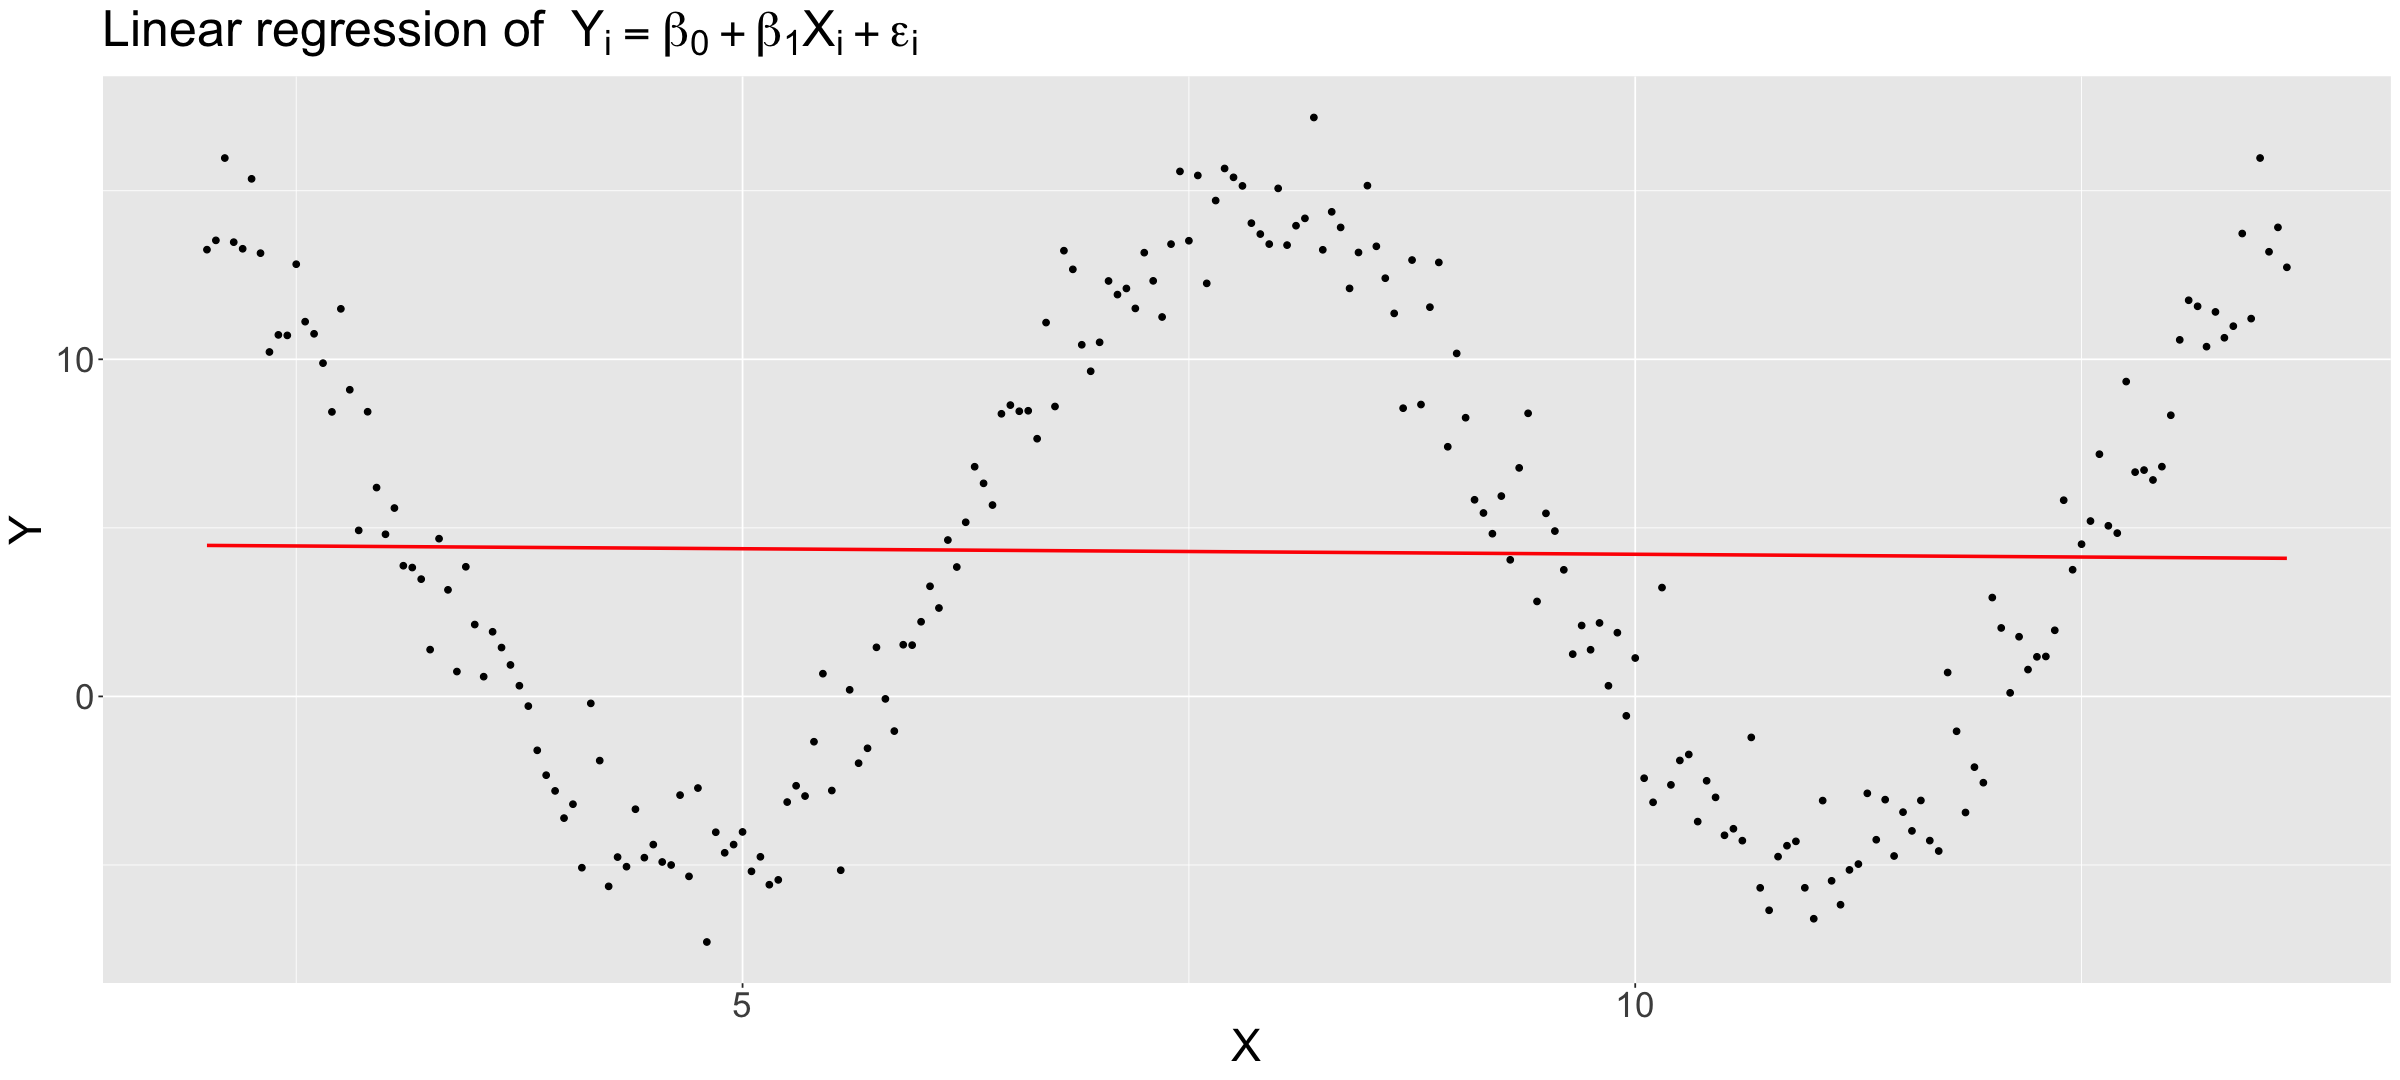

In [10]:
set.seed(123)
sin_data <- tibble(X = seq(2, 13.65, 0.05), Y = 5 + 10 * sin(X) + rnorm(length(seq(2, 13.65, 0.05)), 0, 1.5))
suppressMessages(print(sin_data %>% ggplot() +
  geom_point(aes(X, Y)) +
  geom_smooth(aes(X, Y), method = "lm", se = FALSE, color = "red") +
  ggtitle(bquote("Linear regression of " ~ Y[i] == beta[0] + beta[1] * X[i] + epsilon[i])) +
  theme(
      plot.title = element_text(size = 30),
      axis.text = element_text(size = 21),
      axis.title = element_text(size = 27)
    )))

The code above also fits a linear regression, with `method = "lm"` via `geom_smooth()`, assuming that the "right functional form" is 

$$Y_i = \beta_0^* + \beta_1^* X_i + \varepsilon_i.$$ 

Nonetheless, using `lm()` in `sin_function_model`, the fitted regression line is **almost flat** (i.e., $\hat{\beta}_1^* = -0.033$) and located on $y = 4.545$ (i.e., $\hat{\beta}_0^* = 4.545$). Note that the slope is not even significant given a $p \text{-value} = 0.806$. This result is expected in a **misspecified model** since the OLS method attempts to reduce the squared distance between the observed and estimated response values **across all points**. Hence, this attempt has a serious impact on a sinusoidal curve, like in this example.

In [11]:
sin_function_model <- lm(Y ~ X, data = sin_data)
tidy(sin_function_model) %>% mutate_if(is.numeric, round, 3)
glance(sin_function_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.545,1.136,4.001,0.000
X,-0.033,0.133,-0.246,0.806


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.004,6.886,0.061,0.806,1,-782.543,1571.086,1581.452,11002.15,232,234


```{attention}
Before concluding about the model estimates, we have to make sure that we are setting up an adequate functional form. This is why **feature engineering** is essential as in **DSCI 573**.
```

### 3.7. Restricted Response Ranges in Linear Regression

We initially listed different response types where the ranges are restricted. Now, the next matter to address is how to retain the easiness in model's interpretability. Recall that we might be using the model for inference purposes, and not predictions. Hence, a black-box model will not provide a straightforward interpretation.

We could use the following three modelling alternatives:

- **Data transformations.** For example, logarithmic transformations on the response.
- **Scientifically-backed functions.** We rely on subject-matter expertise. This backs regression modelling with actual scientific models. The theoretically-derived setup will indicate a meaningful relationship between response and regressors, whose parameters will be estimated with the model fitting.
- **Link functions.** This a core concept in GLMs!

### 3.8. Link Function

OLS regression models a continuous response $Y_i$ (a random variable) via its conditioned mean (or expected value) $\mu_i$ subject to $p$ regressors $X_{i,j}$:

$$
\mu_i = \mathbb{E}(Y_i \mid X_{i,1}, \ldots, X_{i,p}) = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_p X_{i,p} \; \; \text{since} \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

Nonetheless, modelling the mean $\mu_i$ of a discrete-type response (such as binary or a count) is not straightforward. Hence, we rely on a **monotonic** and **differentiable** function $h(\mu_i)$ called the **link function**:

$$
h(\mu_i) = \eta_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_p X_{i,p} \; \; \; \; \text{for} \; i = 1, \ldots, n.
$$

```{important}
The link function $h(\mu_i)$ is a crucial element in a GLM since it allows us to establish the functional relationship between the response and the regressor in this class of linear model. Note that the form of this link function will also change how we will interpret our estimated regression coefficients $\hat{\beta}_j$.
```

**Why monotonic and differentiable?** 

- The link function needs to be monotonic so we can allow putting the systematic component $\eta_i$ in terms of the corresponding mean $\mu_i$, i.e.:

$$\mu_i = h^{-1}(\eta_i).$$

- Furthermore, it needs to be differentiable since we rely on **maximum likelihood estimation** to obtain $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_p$.

```{attention}
You will put both characteristics of the link function into practice in the challenging **Exercise 1** of `lab1`.
```

A GLM has the components of the conceptual regression model in a training set of $n$ elements as:

- **Random component.** Each *response* $Y_1,\ldots,Y_n$ is a random variable with its respective mean $\mu_i$.

- **Systematic component.** How the $p$ regressors come into the model denoted as a **linear combination**:

$$
\eta_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_p X_{i,p} \; \; \; \; \text{for} \; i = 1, \ldots, n.
$$ (eq-glm-systematic_component)

- **Link function.** The element that connects the **random component** with the **systematic component** $\eta_i$. The connection is made through $h(\mu_i)$:

$$
h(\mu_i) = \eta_i.
$$

```{important}
The **linear model** in {eq}`eq-glm-systematic_component` does not have an explicit **random component** as in the OLS model with a continuous response. **The randomness is expressed directly in the response $Y_i$ whose mean is $\mu_i$.**
```

## 4. Binary Logistic Regression

Binary Logistic regression is the most basic GLM. You are already familiar with this model from **DSCI 571**. Let us dig into this model by introducing an appropriate dataset.

### 4.1. The Breast Cancer Dataset

The data frame `breast_cancer` is the Wisconsin Diagnostic Breast Cancer dataset ([Mangasarian et al., 1995](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwlV1Nb9QwEB2xPSA4tHQLohRKDoDgsDSJndiRKlApVBx74PNk2bGDKui2jbf8Ff4uM46tbpZKFZdIO55NvNLLeLx-8waAla_z2UpMEAZXtlZKzllZGSk7WTBdtDa3ts6N61aoOnUqjSGWZaAJhkN9zJfML7dHCi-yfnt-MaPmUXTIGjtpTGAi2cDr-rKkvFsPbQwYBpyafxsvQMTDbPEOVxE5yQSH8iZKHH2iKv4TrsMadLQBKk03kU9WagPHAo___7vuwXpMT7ODAU-bcMvNp3A7seOnsJG6QGQxKEzh7pKk4RQ2o91nL6Oi9ast-LN_qvufb94RAX6xvxc-ZIPtkFDXj23vB_rfiR-b9dxmx_3ZdUO_T_TYgFtsfIXHtuOBinaK84wD9-Hz0YdPhx9nsSPEDPeBJWmp6pJ3VS1tzlvR8Ua6WljWlm3RaMkMs52R1jmJWGu4a6wwtugaaauGtQWaH8Da_GzuHkJWVlpwbgpthKOz3aZsmeRWC9mJxnG7DS8STNT5IPyhaMOEO0xF_WkUZ4qrSuTomEB0k-MzgpiK3UXx4un_F_9DX3qvDjCPw2yPMbxfcCPwLXrd6lgngdMmqa5lx6cJqyoiNTzQLz3xeRq4YWZbAYxXXgGJ27CT8K5iZPOqJEFAUnl8dP2XduDOUPVPjObHsLboL92TIGmxCxPx9TteMcDshnf0L2aRR50)). It has a **binary** response `target`: whether the tumour is `benign` or `malignant`.

```{note}
This training dataset contains  569 observations from a digitized image of a fine needle aspirate (FNA) of a breast mass. The dataset details 30 real-valued characteristics (i.e., continuous regressors) plus the binary response and `ID` number. We will start working with the response `target` subject to the regressor `mean_radius`.
```

```{admonition} Main statistical inquiry
Let us suppose we want to assess whether `target` and `mean_radius` are statistically associated and by how much.
```

In [12]:
breast_cancer <- suppressWarnings(suppressMessages(read_csv("datasets/breast_cancer.csv")))

breast_cancer_binary <- breast_cancer %>%
  dplyr::select(mean_radius, target)
breast_cancer_binary

mean_radius,target
<dbl>,<chr>
17.99,malignant
20.57,malignant
19.69,malignant
⋮,⋮
16.60,malignant
20.60,malignant
7.76,benign


We have to set our binary response $Y_i$ mathematically as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th tumour is malignant},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The "1" category is referred as **success**. Note each $Y_i$ is a **Bernoulli** trial whose **probability of success** is $\pi_i$, i.e., 

$$Y_i \sim \text{Bernoulli}(\pi_i).$$

### 4.2. Using Ordinary Least-Squares to Model Probabilities 

We will take a "*naive*" approach to address our main statistical inquiry. Suppose we use the "1" and "0" in the response as probabilities, and we estimate an OLS regression model to predict the mean of $Y_i$ subject to `mean_radius`, $X_{\texttt{mr}_i}$: 

$$
\mathbb{E}(Y_i \mid X_{\texttt{mr}_i}) = \pi_i = \beta_0 + \beta_1 X_{\texttt{mr}_i}
$$

The code below transforms the response `target`, via `mutate()`, as a probability with two possible outcomes: `1` for `malignant` and `0` for `benign`.

In [13]:
breast_cancer_binary <- breast_cancer_binary %>% 
  mutate(target = if_else(target == "malignant", 1, 0))
breast_cancer_binary

mean_radius,target
<dbl>,<dbl>
17.99,1
20.57,1
19.69,1
⋮,⋮
16.60,1
20.60,1
7.76,0


Thus, the plot below shows two subsets of points located on two horizontal lines. The OLS-fitted values of the 569 observations, with `mean_radius` as a regressor, are shown on the blue line. Recall that a probability cannot be negative or larger than $1$. Nonetheless, values larger than $20$ for `mean_radius` generate predictions larger than $1$, which is absurd for a probability. Moreover, small values of `mean_radius` generate predictions of less than $0$, which again does not make sense.

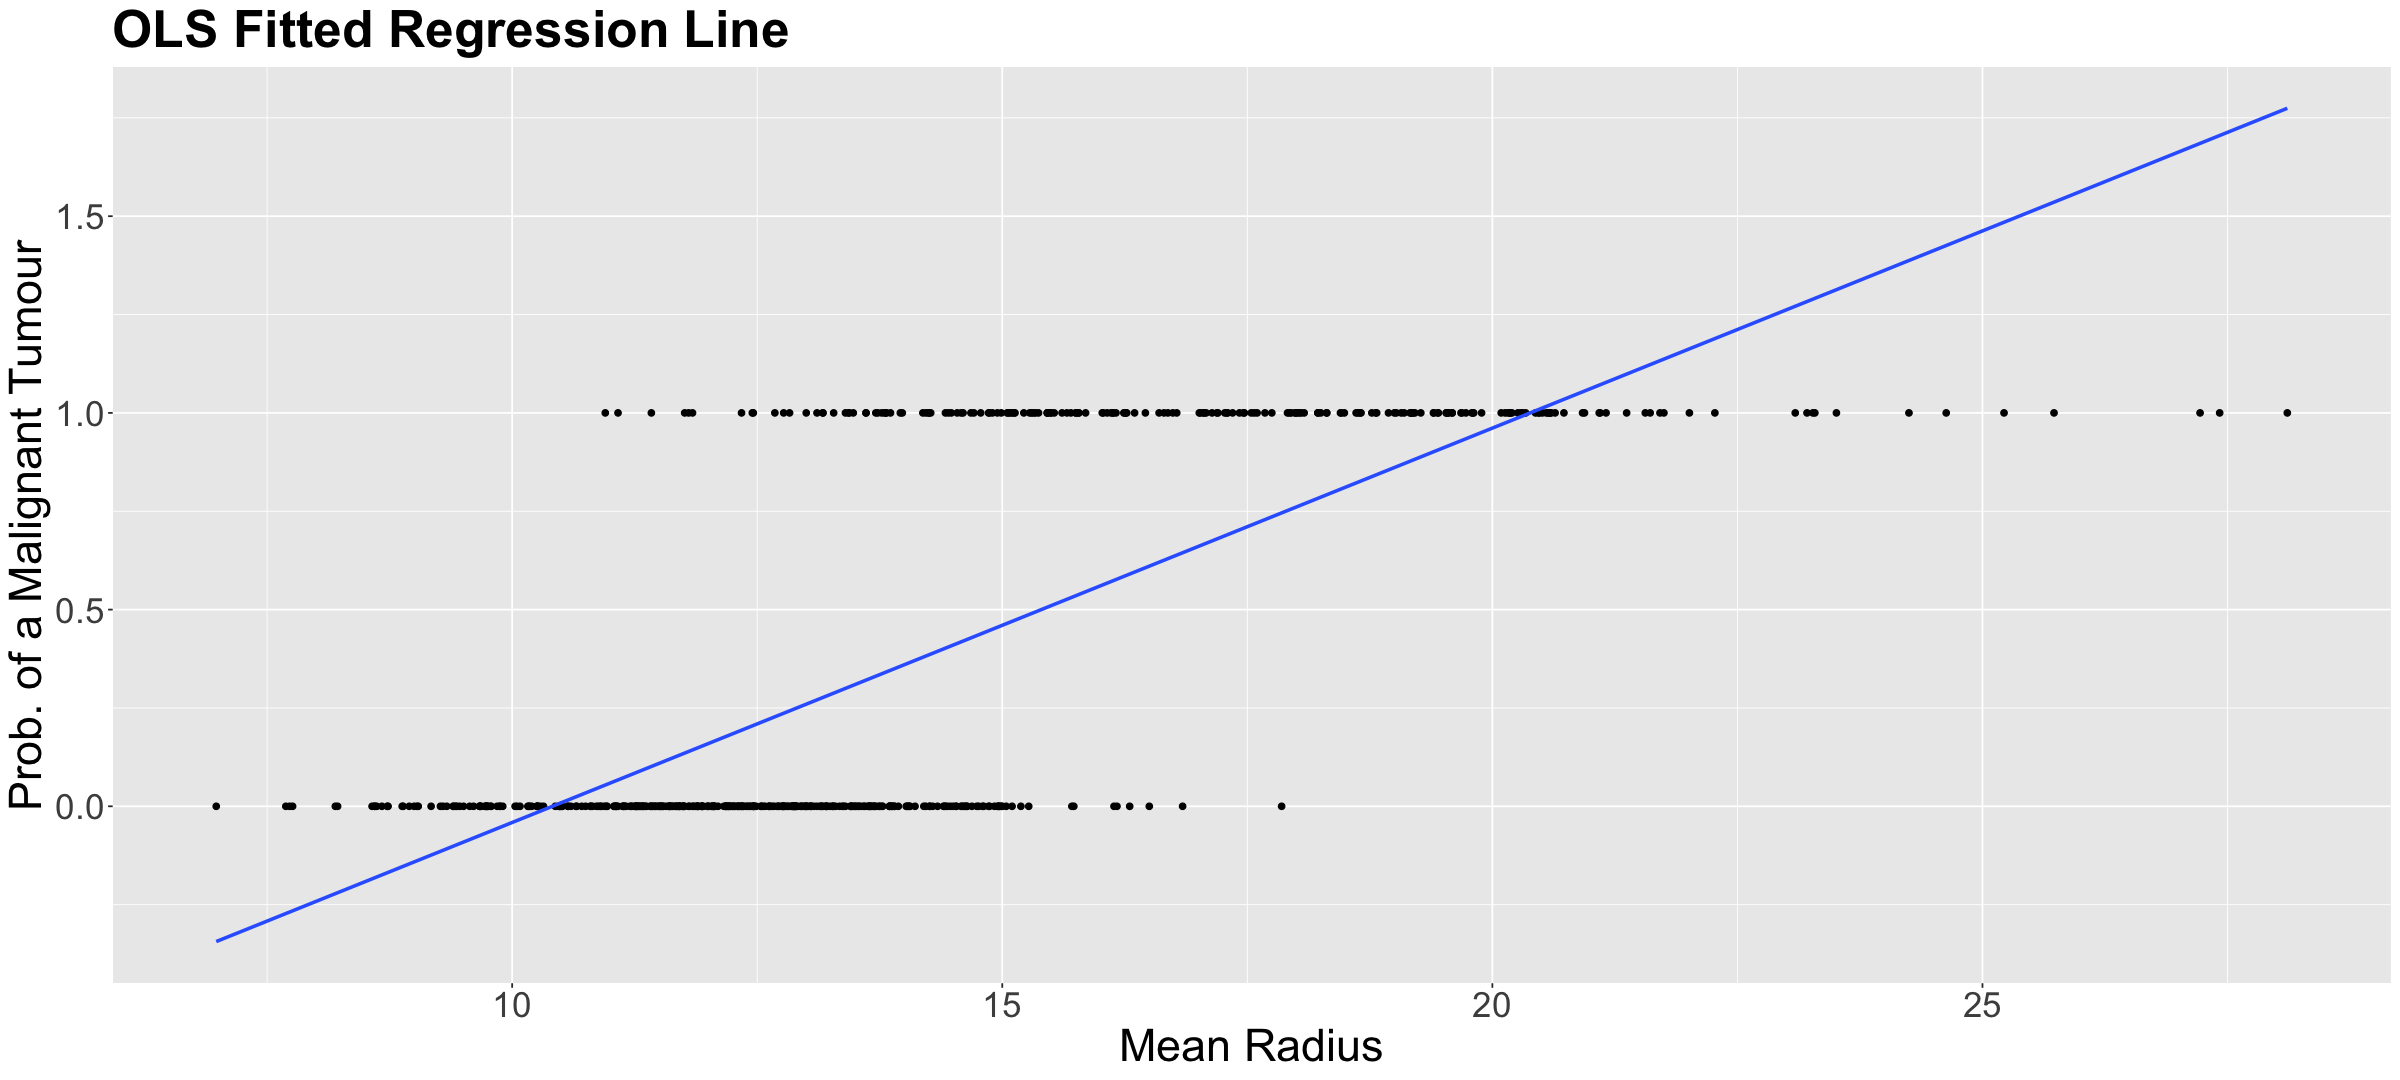

In [14]:
breast_cancer_plot <- breast_cancer_binary %>%
  ggplot() +
  geom_point(aes(mean_radius, target)) +
  geom_smooth(aes(mean_radius, target),
    method = "lm", formula = y ~ x, se = FALSE
  ) +
  labs(y = "Prob. of a Malignant Tumour", x = "Mean Radius") +
  ggtitle("OLS Fitted Regression Line") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) 
breast_cancer_plot

### 4.3. The Logit Function

Now, you might wonder: **is there a way to overcome the above out-of-range issue?** Of course, there is a way involving a link function. Nonetheless, a simple logarithmic transformation will not save the day here since we have $Y_i$ values equal to zero. Therefore, let us play around with the distribution theory from **DSCI 551**. Recall these facts:

```{math}
\begin{gather*}
Y_i \sim \text{Bernoulli}(\pi_i) \\
\mathbb{E}(Y_i) = \pi_i.
\end{gather*}
```

Given that the **mean** of a Bernoulli random variable $Y_i$ is $\pi_i$, we can establish the following link function (which is **monotonic and differentiable**):

$$
h(\pi_i) = \mbox{logit}(\pi_i)= \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i}.
$$

The link function $h(\pi_i)$ is called the **logarithm of the odds** or **logit function**. This logit function $\log\left(\frac{\pi_i}{1 - \pi_i}\right)$ covers the entire real line, which solves the out-of-range problem from OLS in this case.

We already highlighted this link function is monotonic. How can we transform back $h(\pi_i)$ to the probability $\pi_i$? With some algebraic arrangements (part of the challenging **Exercise 1** of `lab1`), we can come up with the following expression:

$$
\pi_i = \frac{\exp \big( \beta_0 + \beta_1 X_{\texttt{mr}_i} \big) }{ \big[ 1 + \exp \big( \beta_0 + \beta_1 X_{\texttt{mr}_i} \big) \big] } \in [0,1].
$$

Note that this whole modelling framework via this link function is called **Binary Logistic regression**.

The plot below fits this **simple** (we only have one regressor!) Binary Logistic regression using `breast_cancer_binary` with `target` as a response and `mean_radius` as a regressor. We can do this via `geom_smooth()` using `method = "glm"` and `method.args = c(family = binomial)`. Then, we obtain the **in-sample predictions** $\hat{\pi}_i$ and connect them as a red line. This red $S$-shaped function above is called the **sigmoid function**. Note this function covers all the real line of `mean_radius` but is constrained between 0 and 1 for the probability of encountering a malignant tumour.

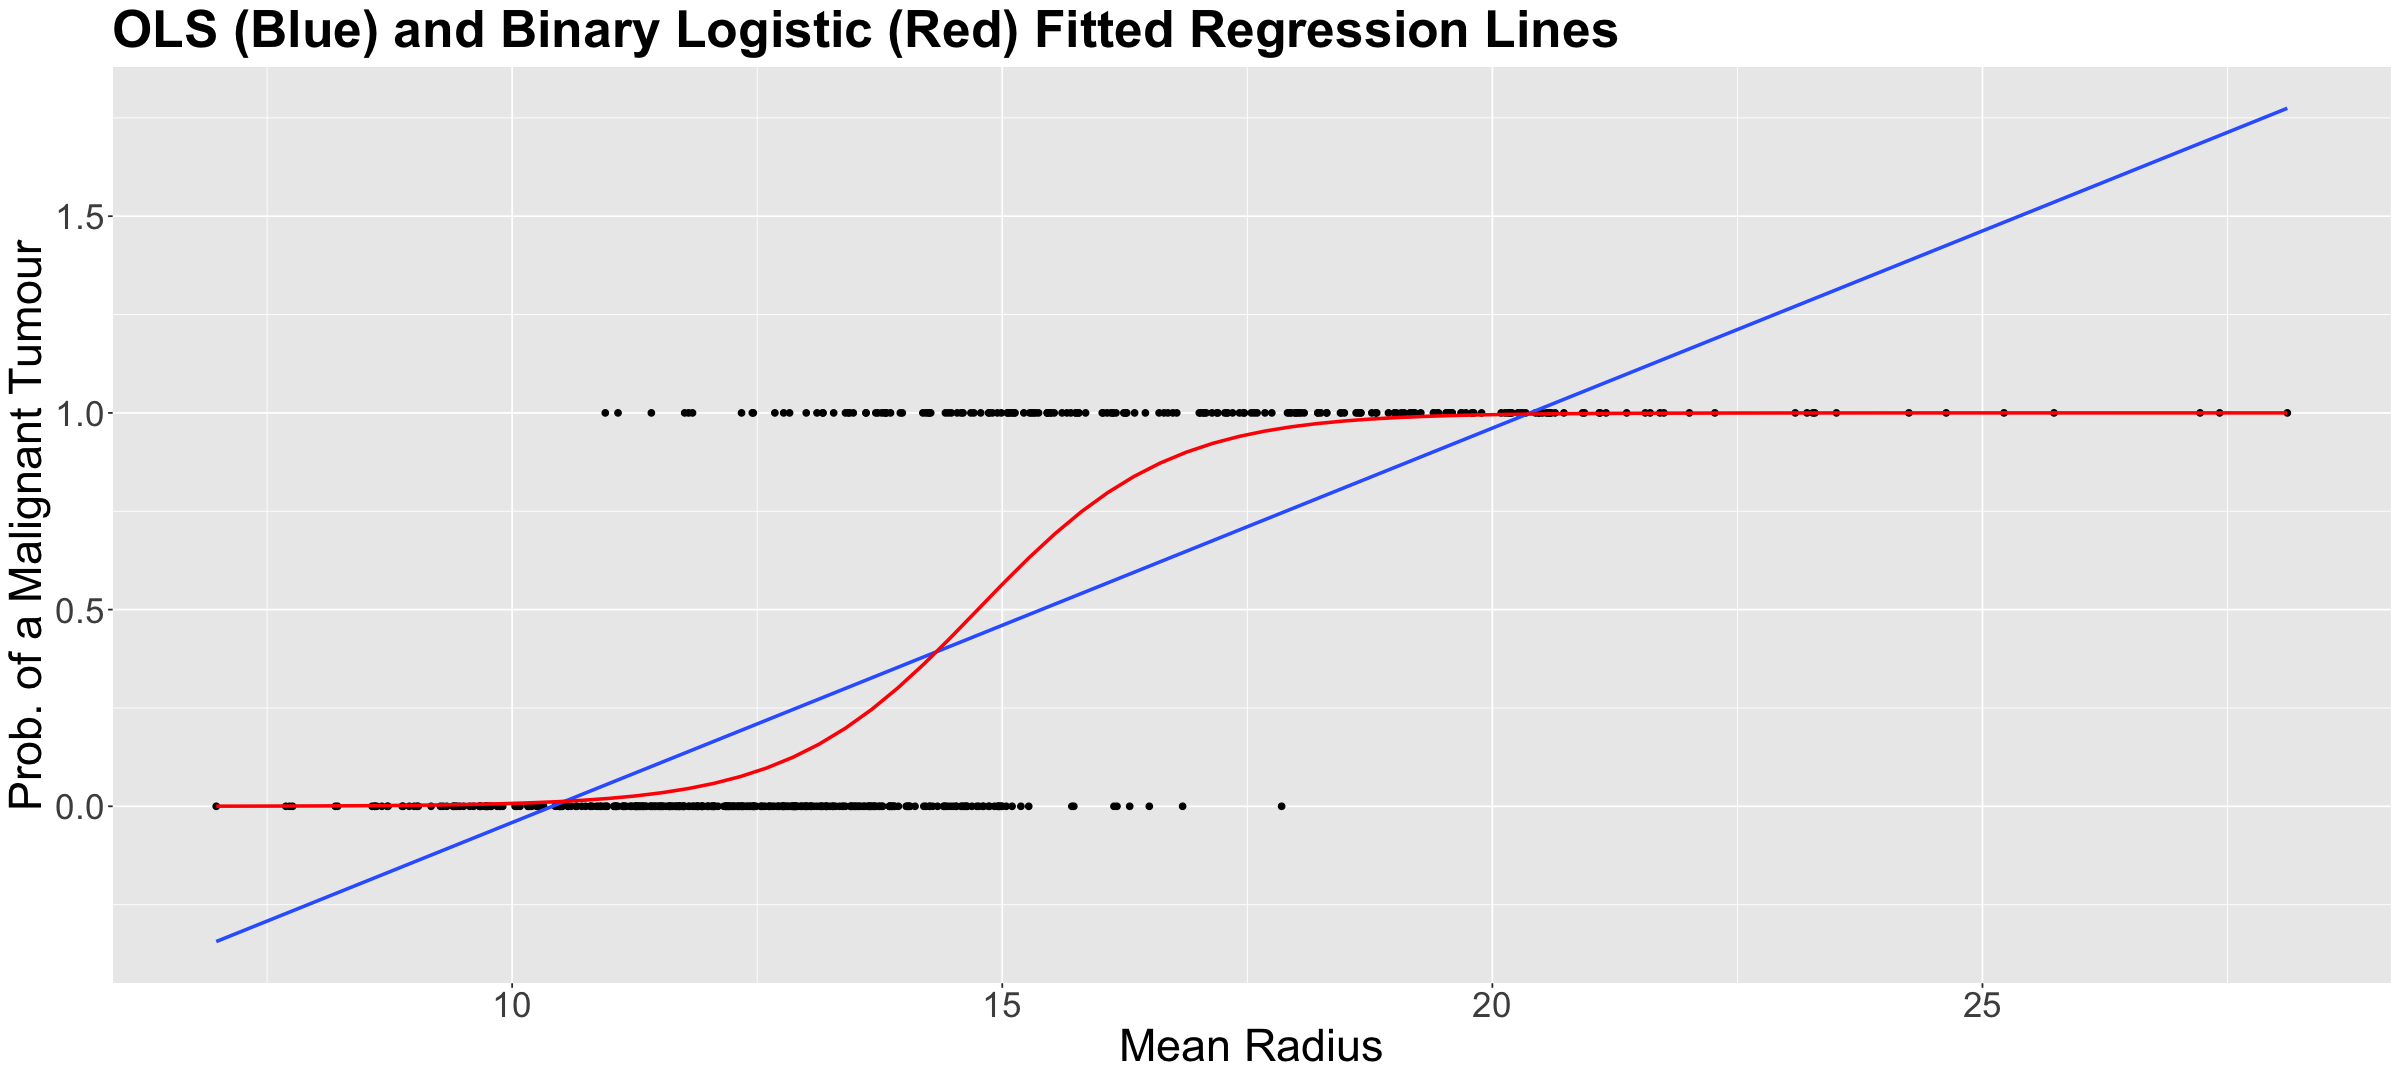

In [15]:
breast_cancer_plot <- breast_cancer_plot +
  geom_smooth(aes(mean_radius, target),
    method = "glm", formula = y ~ x,
    method.args = c(family = binomial), se = FALSE, color = "red"
  ) +
  ggtitle("OLS (Blue) and Binary Logistic (Red) Fitted Regression Lines")
breast_cancer_plot

### 4.4. General Modelling Framework of the Binary Logistic Regression

The Binary Logistic regression model has a response variable in the form:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is a success},\\
0 \; \; \; \; \mbox{otherwise.}
\end{cases}
$$

As the response variable can only take the values $0$ or $1$, the key parameter becomes the probability that $Y_i$ takes on the value of $1$, i.e. the probability of success, denoted as $\pi_i$. Hence:

$$
Y_i \sim \text{Bernoulli}(\pi_i).
$$

The Binary Logistic regression approach models the probability of success, $\pi_i$, of the binary response $Y_i$. To re-express $\pi_i$ **on an unrestricted scale**, the modelling is done in terms of the logit function (the link function in this model). Specifically, $\pi_i$ ($i = 1, 2, \dots, n$) will depend on the values of the $p$ regressors $X_{i, 1}, X_{i, 2}, \dots, X_{i, p}$ in the form:

$$
h(\pi_i) = \mbox{logit}(\pi_i) = \log \bigg( \frac{\pi_i}{1 - \pi_i}\bigg) = \beta_0 + \beta_1 X_{i, 1} + \beta_1 X_{i, 2} + \ldots + \beta_p X_{i, p},
$$

or equivalently

$$
\pi_i = \frac{\exp\big[\mbox{logit}(\pi_i)\big]}{1 + \exp\big[\mbox{logit}(\pi_i)\big]}.
$$

Note that the $\log(\cdot)$ notation in the model above refers to the **natural logarithm**, i.e., **logarithm base $e$**. The equation above for $\pi_i$ shows that this Binary Logistic regression model will result in values of the probability of success $\pi_i$ that are always between 0 and 1. 

```{important}
The response in this GLM is called the log-odds, the logarithm of the odds $\pi_i/(1 - \pi_i)$, the ratio of the probability of the event to the probability of the non-event. For instance, if the event is that the tumour is malignant, it denotes how likely the $i$th tumour is to be malignant compared to how unlikely it is. The coefficient $\beta_j$ ($j = 1, \dots, p$) denotes how much the log-odds increases or decreases when the corresponding continuous regressor changes by one unit
```

### 4.5. Estimation

Under a general framework with $p$ regressors, the **regression parameters** $\beta_0, \beta_1, \dots, \beta_p$ in this model are also unknown. In order to fit the model, we can use the function `glm()` and its argument `family = binomial` (required to specify the binary nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots \hat{\beta}_p$ (note the hat notation).

The estimates are obtained through **maximum likelihood** where we assume a **joint probability mass function of the $n$ responses $Y_i$**. You will put this into practice in the challenging **Exercise 1** of `lab1`.

```{attention}
For the sake of coding clarity, you could also use `family = binomial(link = "logit")`. Nevertheless, `link = "logit"` is a default in `glm()` for Binary Logistic regression. Thus, `family = binomial` suffices when using the logit function.
```

In [16]:
binary_log_model <- glm(as.factor(target) ~ mean_radius,
  data = breast_cancer_binary, family = binomial
)

### 4.6. Inference

We can determine **whether a regressor is statistically associated with the logarithm of the response's odds** through **hypothesis testing** for the parameters $\beta_j$. We will need information about the estimated regression coefficient $\hat{\beta}_j$ and its corresponding variability which is reflected in the **standard error** of the estimate, $\mbox{se}(\hat{\beta}_j)$. 

To determine the **statistical significance** of $\hat{\beta}_j$, you can use the **Wald statistic** $z_j$

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0.
\end{gather*}
```

**A statistic like $z_j$ is analogous to the $t$-value in OLS regression.** However, in Binary Logistic regression, provided the sample size $n$ is large enough, $z_j$ has an **approximately Standard Normal distribution** under $H_0$ rather than a $t$-distribution.

`R` provides the corresponding **$p$-value** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. Hence, a small enough $p$-value (less than the significance level $\alpha$) indicates that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the log-dds and the $j$th regressor. Furthermore, given a specified level of confidence, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** (CIs) for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Now, we can answer the following: **is `mean_radius` statistically associated with the logarithm of the odds of `target`?** We can also use the function `tidy()` from the `broom` package along with argument `conf.int = TRUE` to get the 95% confidence intervals **by default**.

In [17]:
tidy(binary_log_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-15.246,1.325,-11.510,0,-18.034,-12.826
mean_radius,1.034,0.093,11.101,0,0.864,1.230


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So `mean_radius` is statistically associated to the logarithm of the odds of `target`.

### 4.7. Coefficient Interpretation

**What is the interpretation of the estimate $\hat{\beta}_1$ for `mean_radius` on the response `target`?** We have to transform back our estimated coefficient $\hat{\beta_1}$ to the original scale of the odds $\frac{\pi_i}{1 - \pi_i}$. Function `tidy()` has the handy argument `exponentiate = TRUE` which exponentiates the `estimate` column along with the CIs (note the rest of the columns remain untransformed).

In [18]:
tidy(binary_log_model, conf.int = TRUE, exponentiate = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,1.32,-11.51,0,0.00,0.00
mean_radius,2.81,0.09,11.10,0,2.37,3.42


The interpretation is: **"for each unit increase in `mean_radius`, the tumour is 2.81 times more likely to be malignant than to be benign."**

This example does not provide interpretations for **categorical explanatory variables**. As in OLS multiple regression, the model fit will estimate multiple regression coefficients for that categorical explanatory variable, one for each level other than the **baseline level**. The interpretation of each regression coefficient estimated will depend on which category was specified as the baseline category. 

Recall {numref}`dummy-var`, which describes dummy variables for a nominal explanatory variable with $m$ categories, where **Level 1** was specified as the baseline level, so all $m-1$ dummy variables are zero for that level. The estimated regression coefficient for **Level 2** represents how much the log-odds increases or decreases compared to the baseline category. The same interpretation applies to the regression coefficients for levels $3, \dots, m$. If we want to interpret these coefficients on the original scale of the odds $\frac{\pi_i}{1 - \pi_i}$, then we exponentiate each one of these estimated coefficients.

Now, let us fit a second model with two regressors: `mean_radius` ($X_{\texttt{mr}_i}$) and `mean_texture` ($X_{\texttt{mt}_i}$) for the $i$th observation:

$$
\eta_i = \mbox{logit}(\pi_i)= \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i} + \beta_2 X_{\texttt{mt}_i}.
$$

Firstly, we select the necessary columns from our dataset `breast_cancer`.

In [19]:
breast_cancer_binary_2 <- breast_cancer %>%
  dplyr::select(mean_radius, mean_texture, target)
breast_cancer_binary_2

mean_radius,mean_texture,target
<dbl>,<dbl>,<chr>
17.99,10.38,malignant
20.57,17.77,malignant
19.69,21.25,malignant
⋮,⋮,⋮
16.60,28.08,malignant
20.60,29.33,malignant
7.76,24.54,benign


Then, we fit the corresponding Binary Logistic regression.

In [20]:
binary_log_model_2 <- glm(as.factor(target) ~ mean_radius + mean_texture,
  data = breast_cancer_binary_2, family = binomial)
tidy(binary_log_model_2, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-19.849,1.774,-11.189,0,-23.592,-16.615
mean_radius,1.057,0.101,10.417,0,0.872,1.271
mean_texture,0.218,0.037,5.885,0,0.147,0.293


Note that both regressors (`mean_radius` and `mean_texture`) are statistically significant for the response `target` ($p\text{-values} < .001$). Then, we make the corresponding coefficient interpretations:

In [21]:
tidy(binary_log_model_2, conf.int = TRUE, exponentiate = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,1.77,-11.19,0,0.00,0.00
mean_radius,2.88,0.10,10.42,0,2.39,3.57
mean_texture,1.24,0.04,5.89,0,1.16,1.34


The interpretation for `mean_radius` is: **"for each unit increase in `mean_radius`, the tumour is 2.88 times more likely to be malignant than to be benign while holding `mean_texture` constant."**

The interpretation for `mean_texture` is: **"for each unit increase in `mean_texture`, the tumour is 1.24 times more likely to be malignant than to be benign while holding `mean_radius` constant."**

```{attention}
Note that the estimated coefficients for each regressor are standalone. Hence, we have to clarify that each estimate stands while holding the other regressor constant. This same interpretation holds with more than two regressors.
```

### 4.8. Predictions

Suppose we want to predict the odds of a tumour being malignant to being benign using our trained `binary_log_model_2`. This tumour has the following values for `mean_radius` and `mean_texture`: $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$, respectively.

We use `binary_log_model_2` for making such prediction as follows:

```{math}
\begin{gather*} 
\log \bigg( \frac{\hat{\pi}}{1 - \hat{\pi}}\bigg) = \underbrace{-19.849}_{\hat{\beta}_0} + \underbrace{1.057}_{\hat{\beta}_1}(16) + \underbrace{0.218}_{\hat{\beta}_2}(20) = 1.43 \\
\frac{\hat{\pi}}{1 - \hat{\pi}} = 4.17.
\end{gather*}
```

We can use the function `predict()` via the argument `type = "link"` to obtain the predicted logarithm of the odds. Then, we exponentiate it to get the predicted odds.

In [22]:
round(exp(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "link"
)), 2)

1 
4.17

Hence, a tumour with $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ is predicted to be 4.17 times more likely to be malignant than benign.

**Can We Predict Probabilities For Classification Purposes?**

Using the function `predict()` via the argument `type = "response"` with the object `binary_log_model_2`, we can obtain the estimated probability for a tumour to be malignant with the following values for `mean_radius` and `mean_texture`: $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ respectively.

In [23]:
round(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "response"
), 2)

1 
0.81

Hence, a tumour with $x_{\texttt{mr}} = 16$ and $ x_{\texttt{mt}} = 20$ has a predicted probability of 0.81 of beign malignant.

### (Optional) 4.9. Model Diagnostics

**Model diagnostics** in GLMs are not the same ones from OLS regression and **there is still an open research field for them**. We will check two different plots for the Binary Logistic regression model.

#### 4.9.1. Deviance Residuals

We can obtain more than one class of residual in a Binary Logistic regression. However, we will concentrate on the **deviance residuals**. A deviance residual for the $i$th binary observation $y_i$ is defined as:

$$
d_i=
\begin{cases}
\sqrt{-2 \log \hat{\pi}_i} \; \; \; \; \mbox{if $y_i = 1$},\\
-\sqrt{-2 \log (1 - \hat{\pi}_i}) \; \; \; \; \mbox{if $y_i = 0$}.
\end{cases}
$$

where $\hat{\pi}_i$ is the predicted probability of success coming from the model.

The sum all the $n$ $d_i$s in the model is the deviance $D_p$ (column `deviance` above via function `glance()`).

In [24]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


With a large enough sample size $n$, the deviance residuals are approximately normally distributed. Hence, we could use **$Q$-$Q$ plots** for both models. To deliver these $Q$-$Q$ plots, we need to extract the deviance residuals from the Binary Logistic regression models. We can do it via the function `residuals()` with the argument `type = "deviance"`. Below you can find the code to extract these residuals from `binary_log_model` and `binary_log_model_2`.

In [25]:
binary_log_model_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model, type = "deviance"))
binary_log_model_dev_residuals

,dev_residuals
,<dbl>
1,0.26282111
2,0.06983906
3,0.10995490
⋮,⋮
567,0.52511283
568,0.06876592
569,-0.03815040


In [26]:
binary_log_model_2_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model_2, type = "deviance"))
binary_log_model_2_dev_residuals

,dev_residuals
,<dbl>
1,0.65442997
2,0.07886868
3,0.08590128
⋮,⋮
567,0.20788406
568,0.02201645
569,-0.06078262


We can code these plots "by hand" using `ggplot2()`, but we will save up time using package `qqplotr`. The file `support_functions.R` in the repo's folder `scripts` contains the function `qqplot_dev_residuals()`, which uses `qqplotr`'s tools. This function shows the $Q$-$Q$ plot for the deviance residuals of each fitted model. It needs these residuals in the `data` argument and a proper `title`. 

The advantage of `qqplotr` is that, besides the usual 45° degree line, it allows us to plot 95% (by default) **confidence bands**. Since we cannot expect all points to be on the 45° degree line, we still expect them to be within the confidence bands. **Nonetheless, we have serious non-normality issues on both models for the most extreme observations, as shown below.**

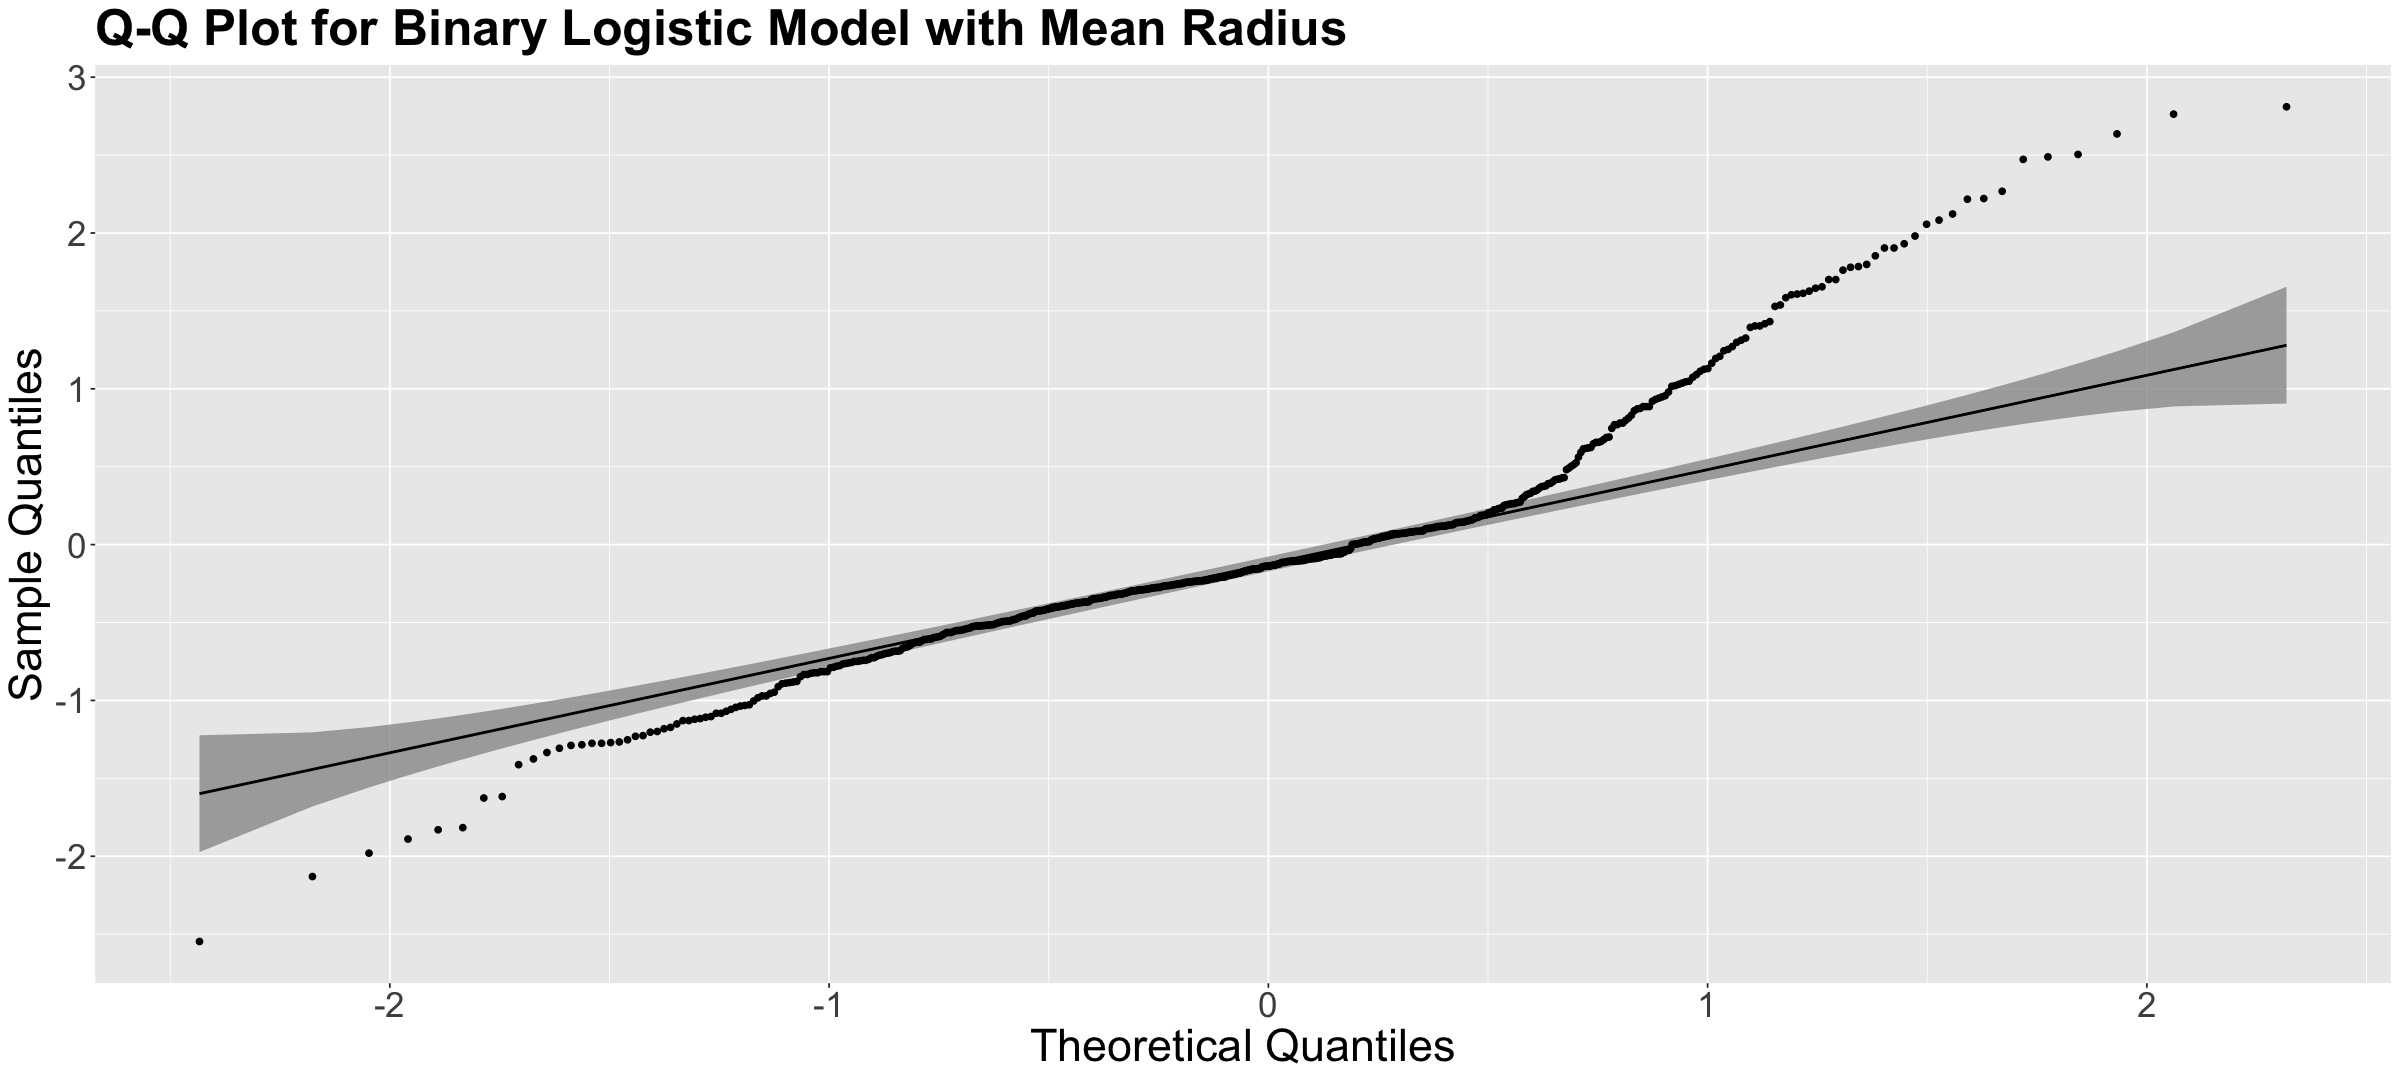

In [27]:
qqplot_dev_residuals(
  data = binary_log_model_dev_residuals,
  title = "Q-Q Plot for Binary Logistic Model with Mean Radius"
)

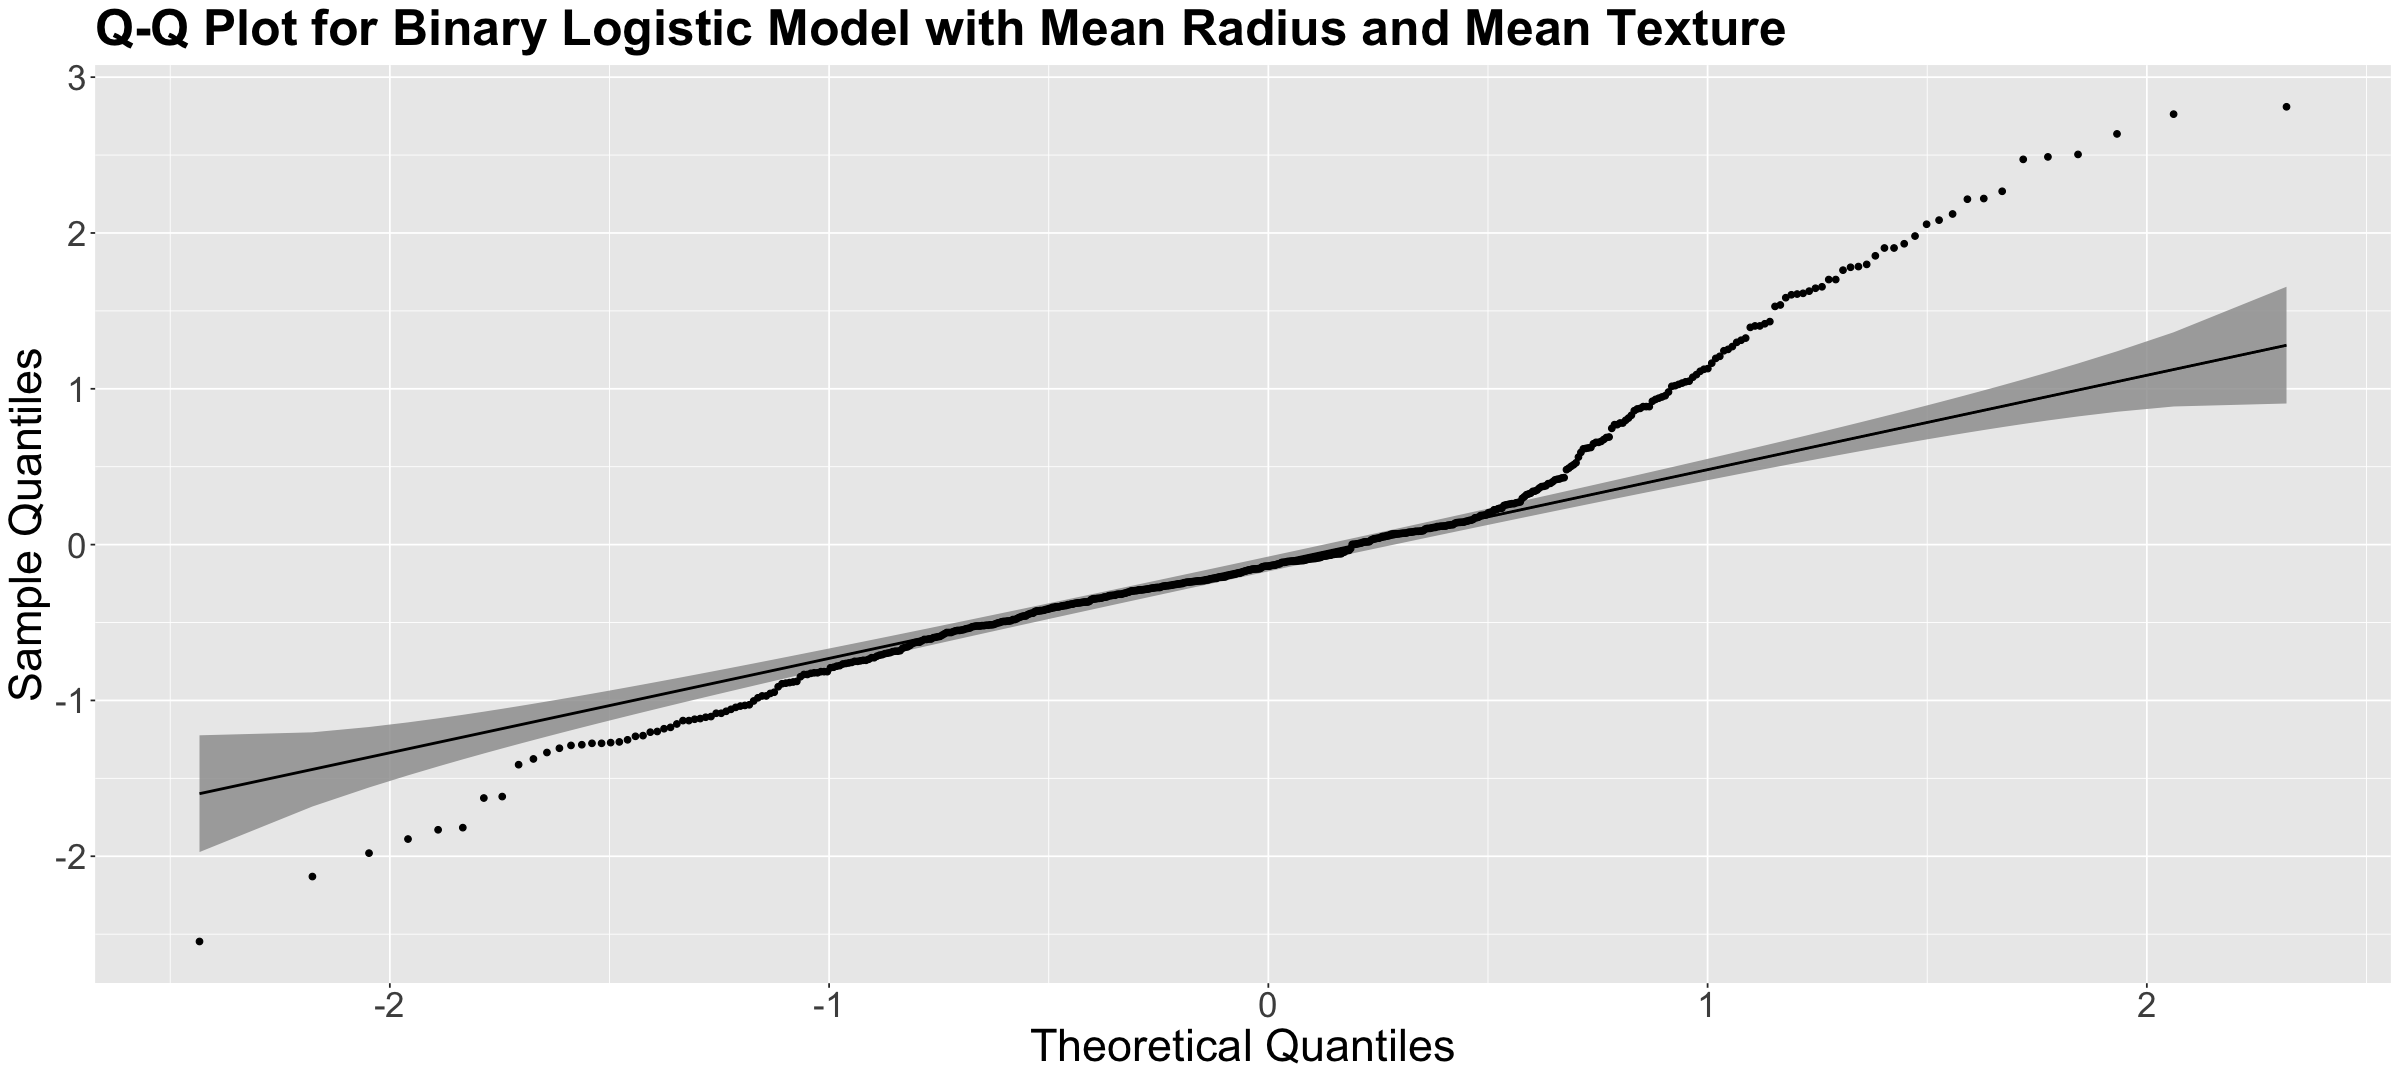

In [28]:
qqplot_dev_residuals(
  data = binary_log_model_2_dev_residuals,
  title = "Q-Q Plot for Binary Logistic Model with Mean Radius and Mean Texture"
)

#### 4.9.1. Binned Residual Plots

A plot of **the deviance residuals $d_i$ versus fitted values $\mbox{logit}(\pi_i)$** as the one below might not be too informative. This class of diagnostic plot makes sense for OLS to verify we are fulfilling **the constant variance assumption** on the random component. Still, it is not the case for Binary Logistic regression **since each response is an independent Bernoulli trial with its parameter $\pi_i$**.  

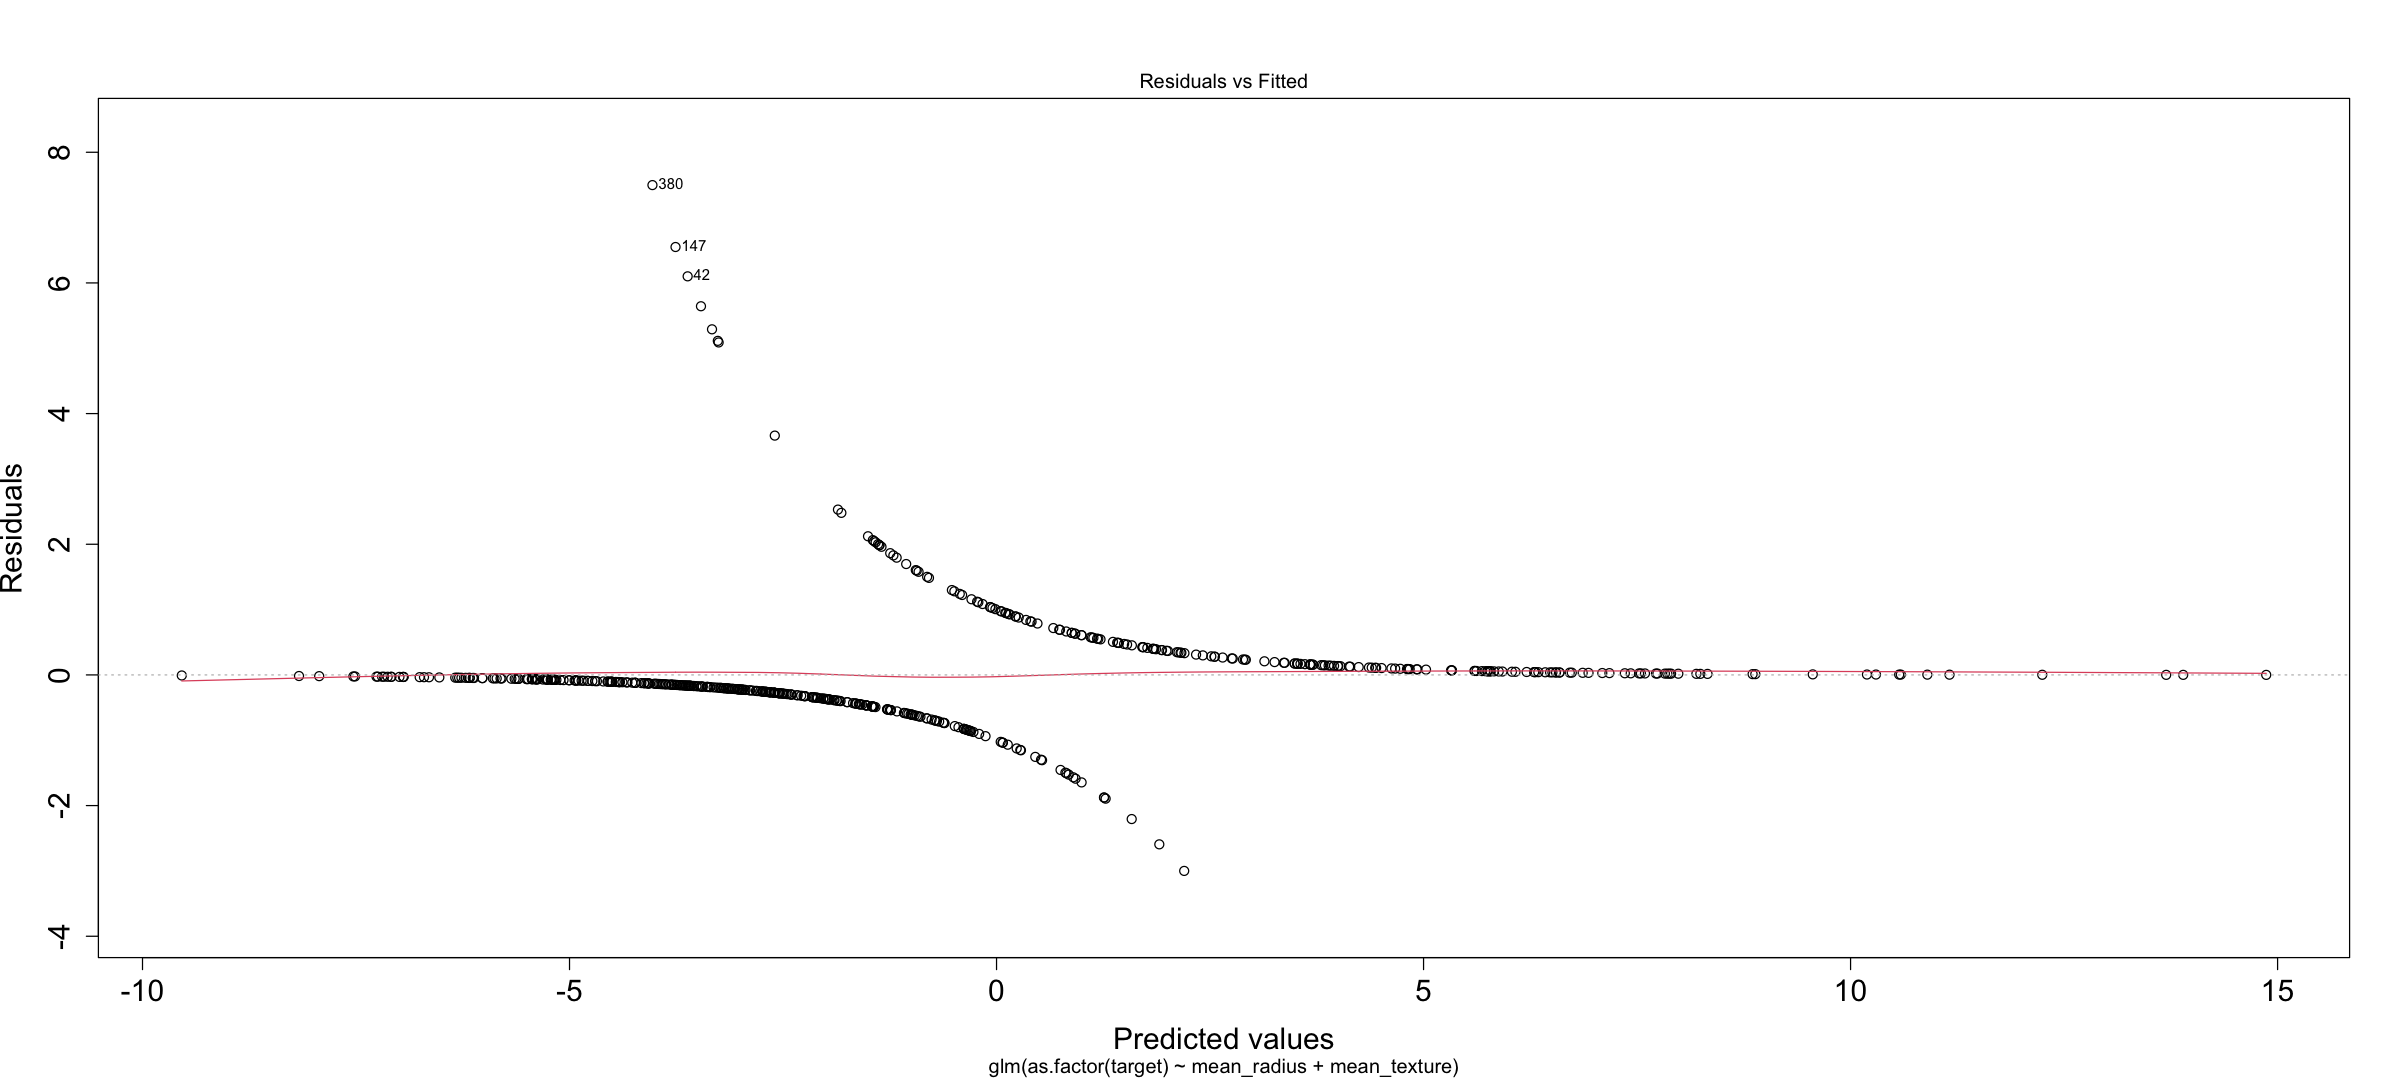

In [29]:
plot(binary_log_model_2, 1, cex.lab = 1.5, cex.axis = 1.5)

Besides deviance residuals, the Binary Logistic regression model has the $i$th **raw residual** $r_i$ as the difference between the binary observed $y_i$ and the fitted value $\hat{\pi}_i$:

$$
r_i = y_i - \hat{\pi}_i \in [-1, 1]
$$

[Gelman and Hill (2007)](http://webcat2.library.ubc.ca/vwebv/search?searchArg=Data%20analysis%20using%20regression%20and%20multilevel%2Fhierarchical%20models%20%2F&searchCode=TALL&searchType=1) recommend using **binned residual plots**. These plots are available via the package `performance` and its function `binned_residuals()`. Its argument is the fitted model as in the code below. The output is a data frame used to build the corresponding diagnostic plot.

In [30]:
diagnostic_bins <- binned_residuals(binary_log_model_2)
diagnostic_bins

,xbar,ybar,n,x.lo,x.hi,se,ci_range,CI_low,CI_high,group
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0009379625,-0.0009379625,23,7.190053e-05,0.001845559,0.0001917538,9.783537e-05,-0.001129716,-0.0007462087,no
2,0.0030236387,-0.0030236387,24,1.897157e-03,0.004319643,0.0003304141,1.685817e-04,-0.003354053,-0.0026932246,no
3,0.0054739696,-0.0054739696,24,4.374413e-03,0.007189815,0.0003298181,1.682777e-04,-0.005803788,-0.0051441514,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,0.9953239,0.0046760770,24,0.9918863,0.9973316,8.014352e-04,0.0004089030,0.0038746418,0.0054775122,no
23,0.9986466,0.0013533920,24,0.9976117,0.9994714,2.157605e-04,0.0001100839,0.0011376315,0.0015691525,no
24,0.9998101,0.0001898535,24,0.9994960,0.9999997,7.154299e-05,0.0000365022,0.0001183105,0.0002613965,no


Then, we can obtain the binned residual plot via the function `plot()`. The resulting plot is a `ggplot` object.

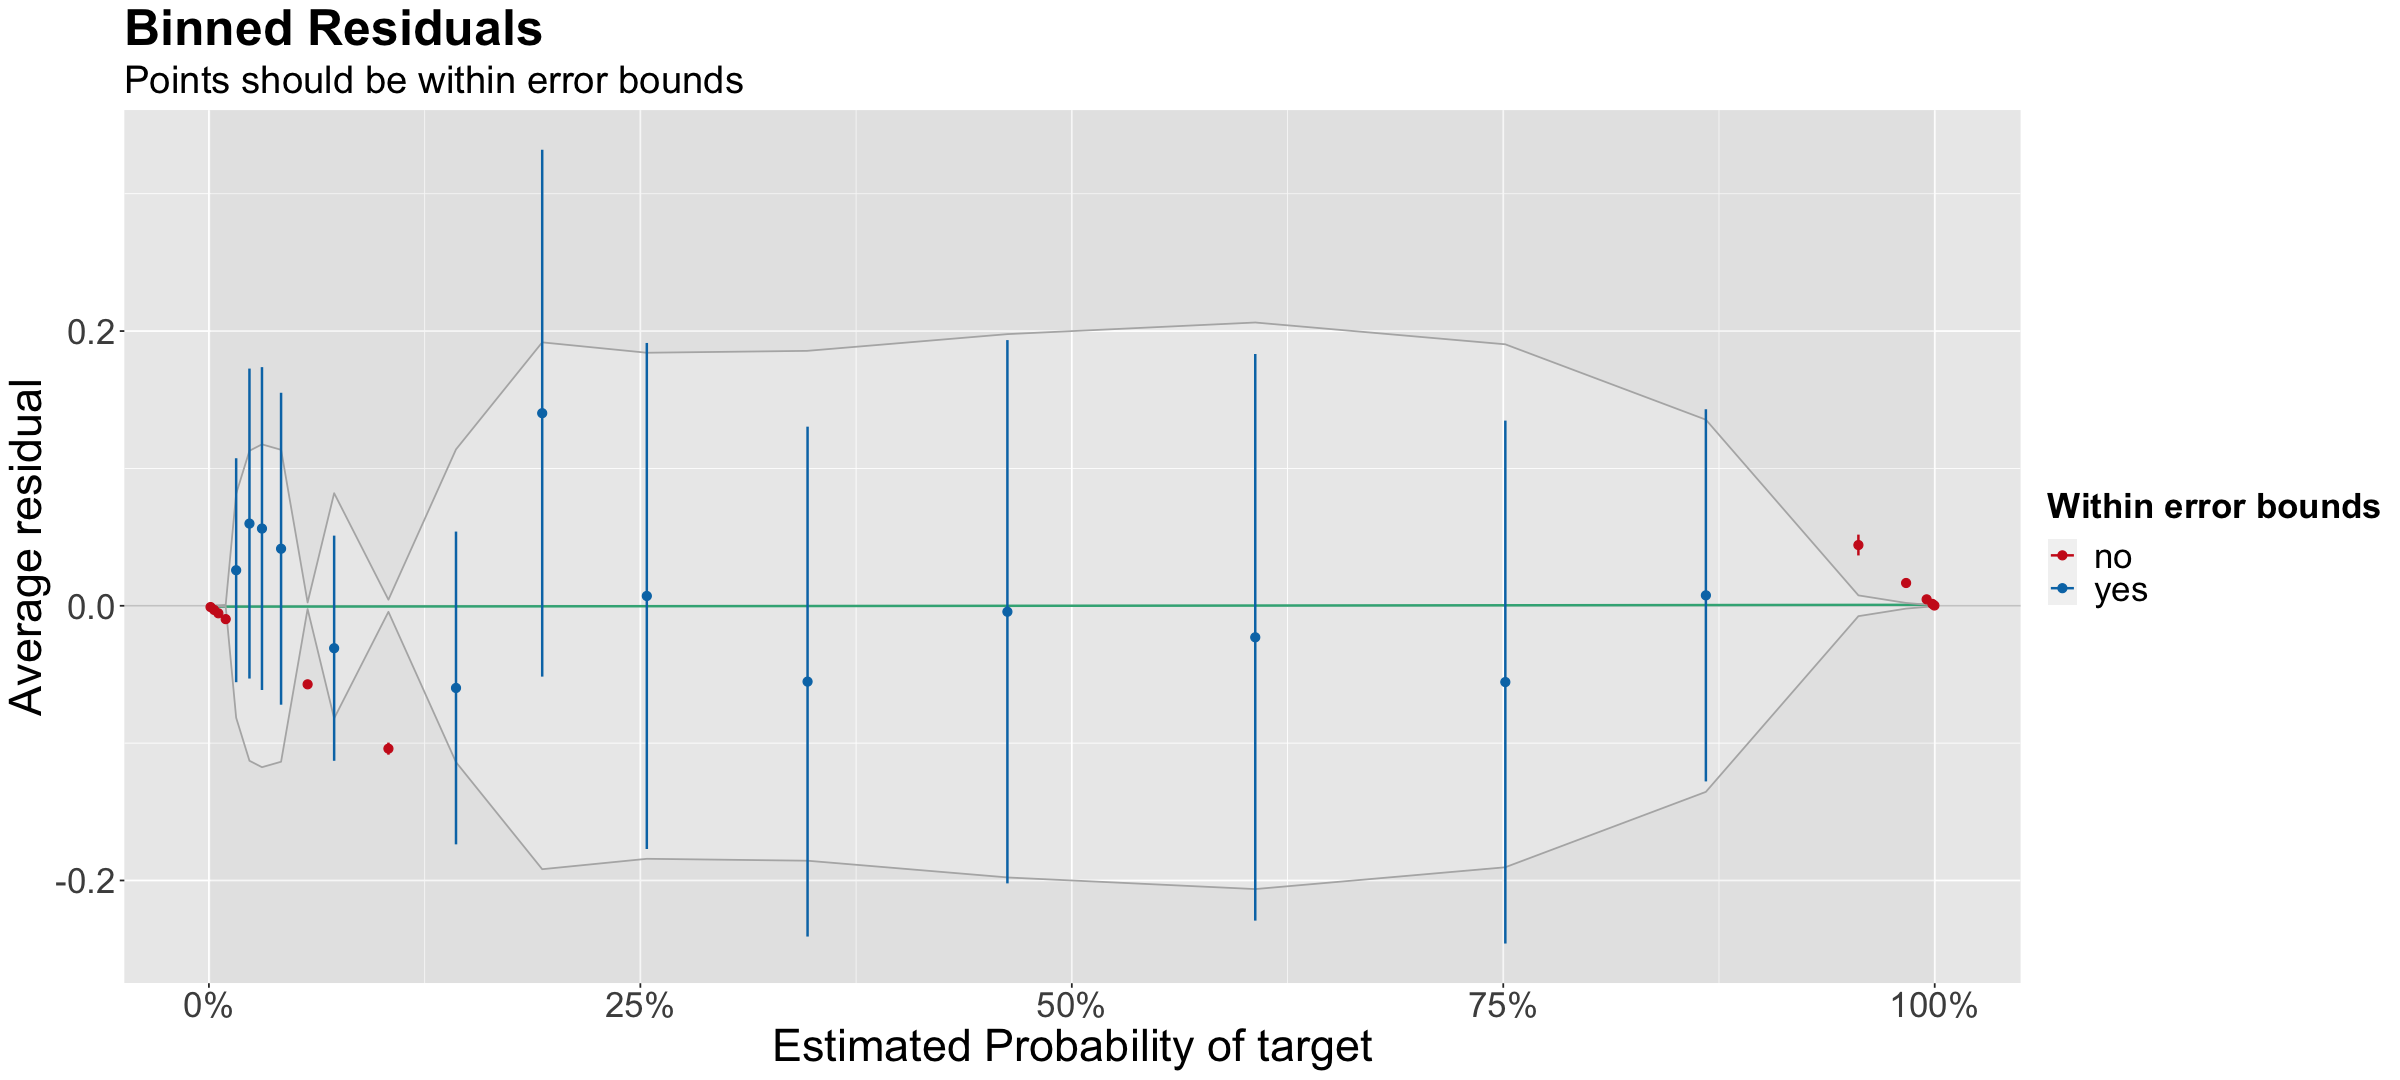

In [31]:
plot(diagnostic_bins) +
  theme(
    plot.title = element_text(size = 30, face = "bold"),
    plot.subtitle = element_text(size = 23), 
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21),
    legend.title = element_text(size = 21, face = "bold")
  )

The plot above corresponds to `binary_log_model_2`. Function `binned_residuals()` does the following:

- **Unless specified**, the **default number of bins** is $\lceil \sqrt{n} \rceil$ as in the ceiling function: `ceiling(sqrt(n))`. For the dataset `breast_cancer` we have $n = 569$, leading to 24 bins (i.e. 24 points in the plot).
- The $n$ **fitted values** $\hat{\pi}_i$ are ordered from smallest to largest.
- The ordered fitted values $\hat{\pi}_1 < \hat{\pi}_2 < \dots < \hat{\pi}_n$ are equally split in the $\lceil \sqrt(n) \rceil$ bins.
- The respective average fitted value per bin is mapped onto the $x$-axis.
- The corresponding average raw residual $\bar{r}_j$ for the $j$th bin is mapped on the $y$-axis. Recall the $i$th raw residual is $r_i = y_i - \hat{\pi}_i$.
- The **95% bounds of confidence** are computed as $\pm 1.96 \times \left( \frac{s_{r_j}}{\sqrt{n_j}} \right)$ **centred at $0$ on the $y$-axis**; where $s_{r_j}$ is the **sample standard deviation** of the raw residuals in the $j$th bin with $n_j$ observations, and $1.96$ is the $97.5th$ percentile of the Standard Normal distribution.
- **One would expect to have $95\%$ of the points to be within the bounds to have a good model fit.**

```{caution}
Note this plot also shows the corresponding **95% CIs** (**as vertical lines**) for each $\bar{r}_j$ as follows:

$$\bar{r}_j \pm 1.96 \times \left( \frac{s_{r_j}}{\sqrt{n_j}} \right).$$
```

## 5. Wrapping Up

- OLS regression might not be suitable in many different cases.
- One possible approach is a response transformation to get rid of range issues.
- We can also rely on subject-matter expertise in our regression modelling.
- GLMs are the way to go in regression analysis when the response is not continuous, and we need to perform inference.
- We started with the most basic GLM: Binary Logistic regression.